<a href="https://colab.research.google.com/github/LinhNH2003/Fundamental-ML/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mini-Project for Fundamentals of Machine Learning Course**
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. **Prerequisite**
This section provides some basic steps for accessing and visualizing the dataset.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from itertools import combinations

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
!pip install mega.py

# Sử dụng mega.py để tải tệp từ Mega.nz
from mega import Mega

# Khởi tạo đối tượng Mega
mega = Mega()
# Nếu tệp công khai, bạn có thể sử dụng mà không cần đăng nhập
m = mega.login()

In [ ]:
# Tải tệp từ Mega.nz
url = 'https://mega.nz/file/foM2wDaa#GPGyspdUB2WV-fATL-ZvYj3i4FqgbVKyct413gxg3rE'
m.download_url(url, '/content/')
# import data
import pandas as pd
df = pd.read_csv('/content/icml_face_data.csv')
df.head()

emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

In [ ]:
#Thông tin của dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
dtypes: int64(1), object(1)
memory usage: 560.9+ KB


In [ ]:
#Kiểm tra giá trị trùng lặp
df.duplicated().sum()

1793

In [ ]:
#Loại bỏ giá trị trùng
df= df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34094 entries, 0 to 35885
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  34094 non-null  int64 
 1   pixels   34094 non-null  object
dtypes: int64(1), object(1)
memory usage: 799.1+ KB


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)


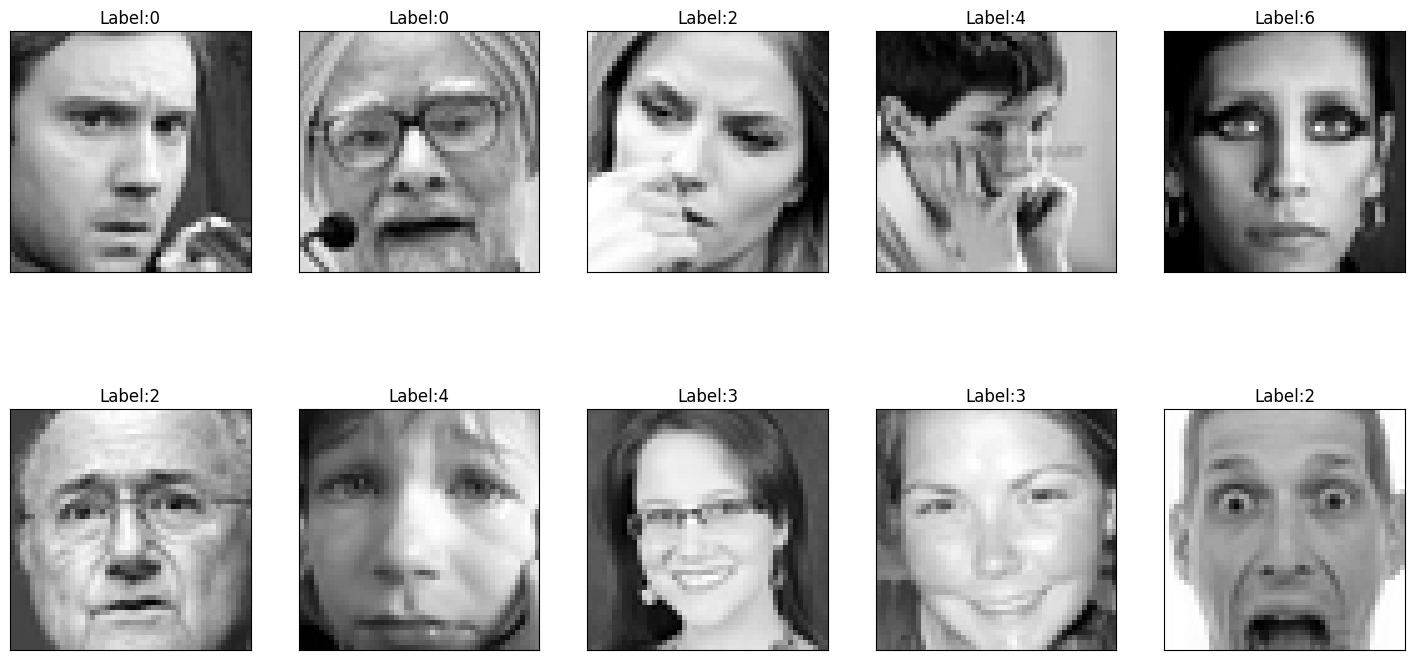

In [ ]:
## showing images here
show_img(images, labels)

Dữ liệu bao gồm các hình ảnh khuôn mặt có thang độ xám **48x48 pixel**. Các khuôn mặt đã được đăng ký tự động sao cho khuôn mặt ít nhiều được căn giữa và chiếm cùng một khoảng không gian trong mỗi hình ảnh. Nhiệm vụ là phân loại từng khuôn mặt dựa trên cảm xúc thể hiện trên nét mặt thành một trong bảy loại:

| Categorie | Emotion  |
|-----------|----------|
| 0         | Angry    |
| 1         | Disgust  |
| 2         | Fear     |
| 3         | Happy    |
| 4         | Sad      |
| 5         | Surprise |
| 6         | Neutral  |


In [ ]:
df["emotion"].unique()

array([0, 2, 4, 6, 3, 5, 1])

## **1.1 Overview**



In [ ]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels and pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(data['emotion'])

    for i, pixels in enumerate(data['pixels']):
        image = np.fromstring(pixels, dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def plot_examples(df, train_images, train_labels, label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = df[df['emotion'] == label].index[i]
        axs[i].imshow(train_images[idx], cmap='gray')
        axs[i].set_title(emotions[label])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_all_emotions(df, train_images, train_labels):
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = df[df['emotion'] == i].index[0]
        axs[i].imshow(train_images[idx], cmap='gray')
        axs[i].set_title(emotions[i])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    bar_label = list(emotions.values())

    axs[0].imshow(test_image_array[image_number], cmap='gray')
    axs[0].set_title(emotions[test_image_label[image_number]])

    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()

    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1
    df_array2['emotion'] = array2

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = list(emotions.values())

    y = df_array1['emotion'].value_counts().sort_index()
    for key in range(len(emotions)):
        if key not in y:
            y[key] = 0
    axs[0].bar(x, y, color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts().sort_index()
    for key in range(len(emotions)):
        if key not in y:
            y[key] = 0
    axs[1].bar(x, y)
    axs[1].set_title(title2)
    axs[1].grid()

    plt.show()

**Phân bố của các emotion trong tập dữ liệu**

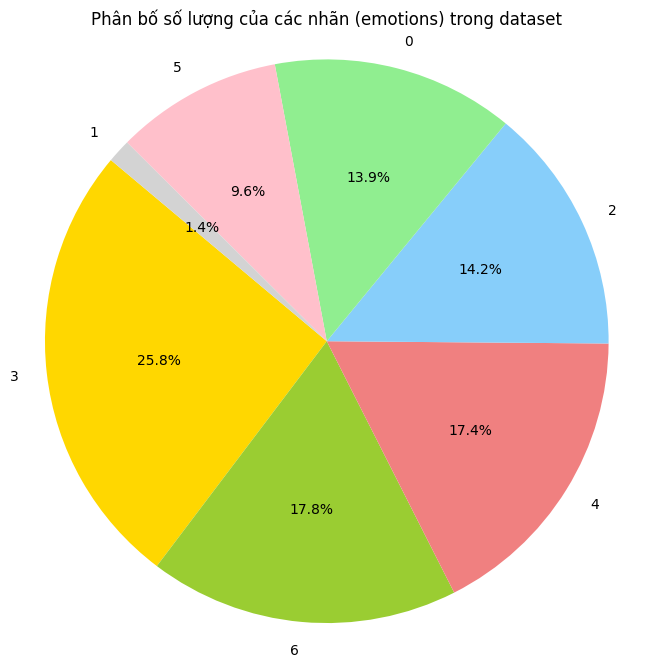

In [ ]:
# Phân phối của các nhãn (emotions)
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'lightgrey']
plt.figure(figsize=(8, 8))
labels = df['emotion'].value_counts().index
sizes = df['emotion'].value_counts().values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Phân bố số lượng của các nhãn (emotions) trong dataset')
plt.axis('equal')
plt.show()

In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
train_images, train_labels = prepare_data(df)

**Trường hợp từng emotion**

- **Angry**

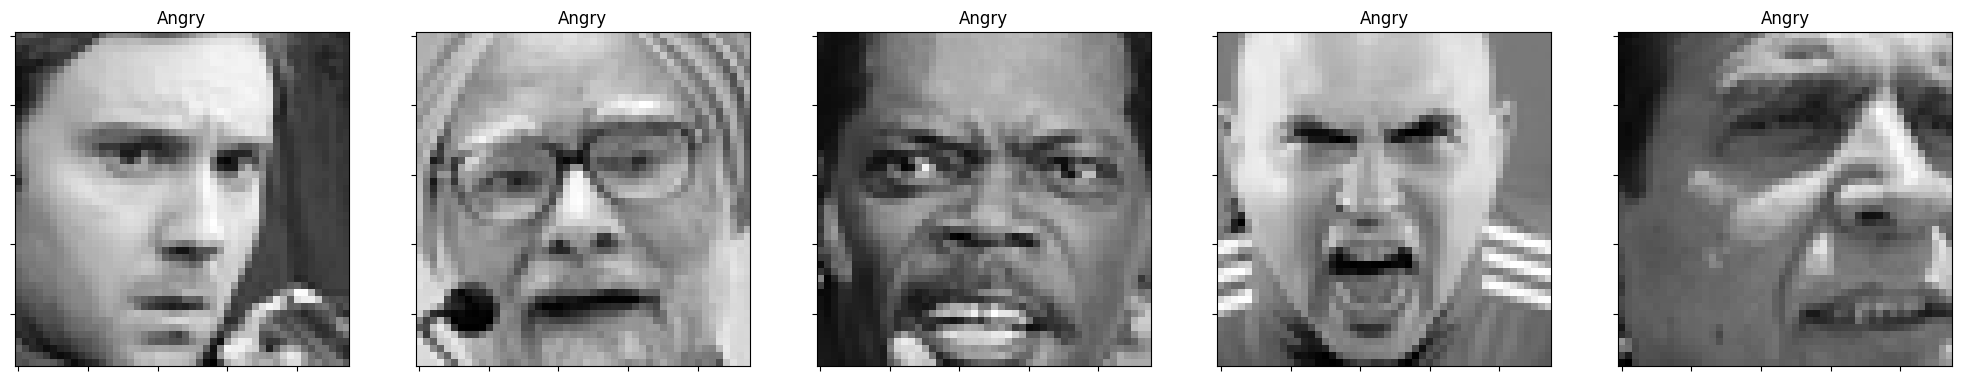

In [ ]:
plot_examples(df, train_images, train_labels, label=0)

- **Disgust**

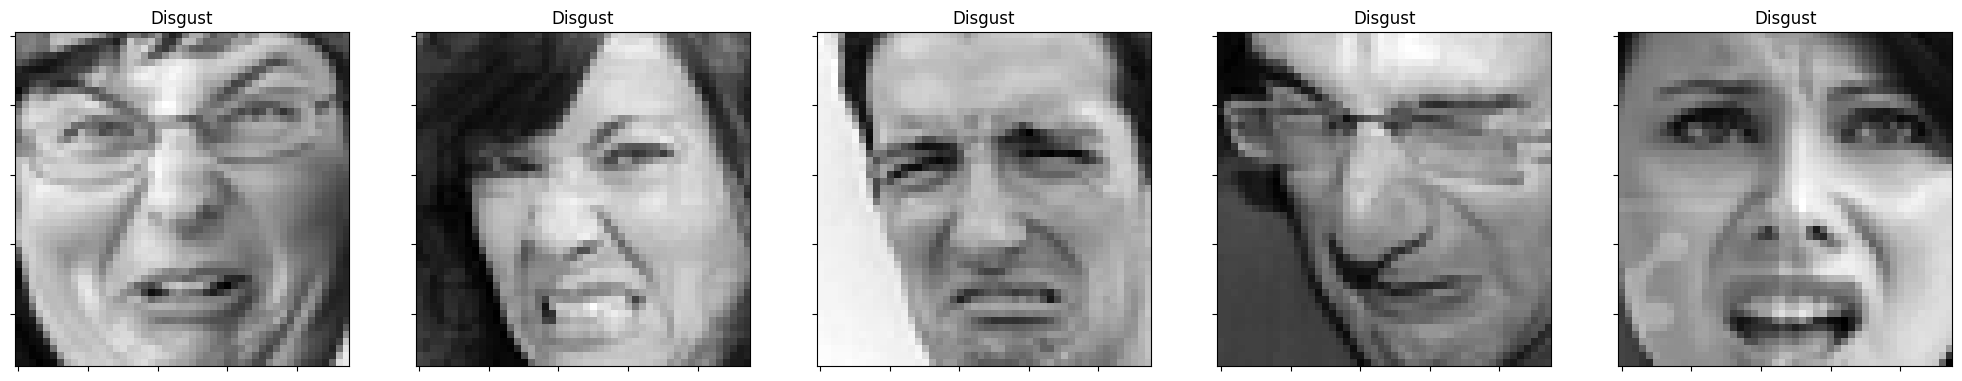

In [ ]:
plot_examples(df, train_images, train_labels, label=1)

- **Fear**

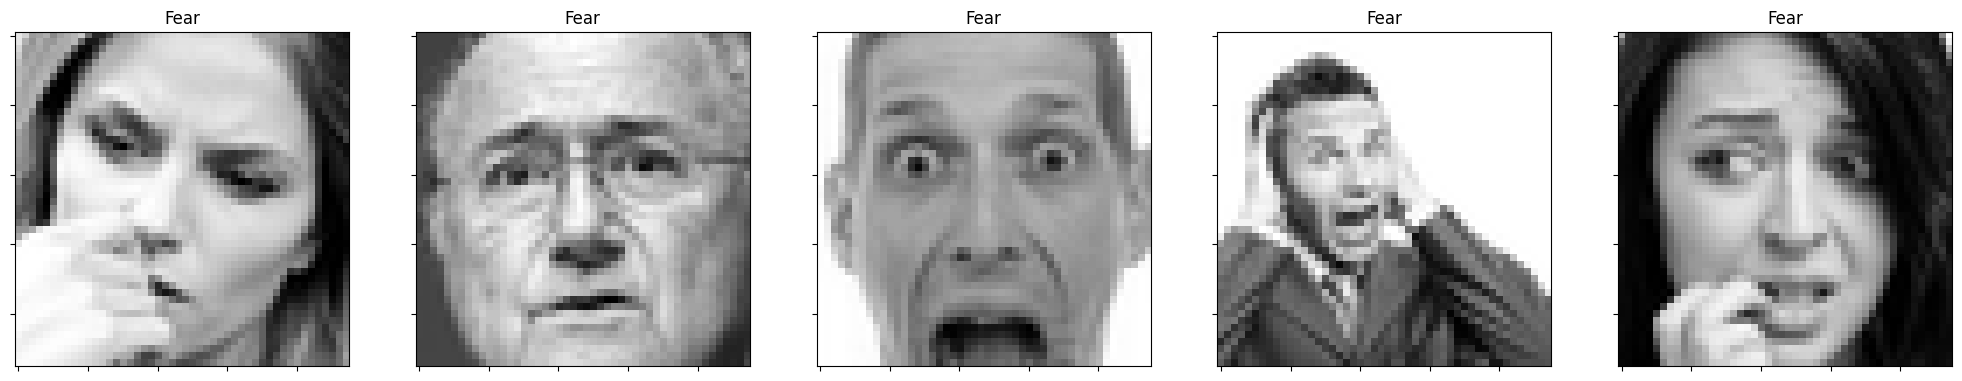

In [ ]:
plot_examples(df, train_images, train_labels, label=2)

- **Happy**

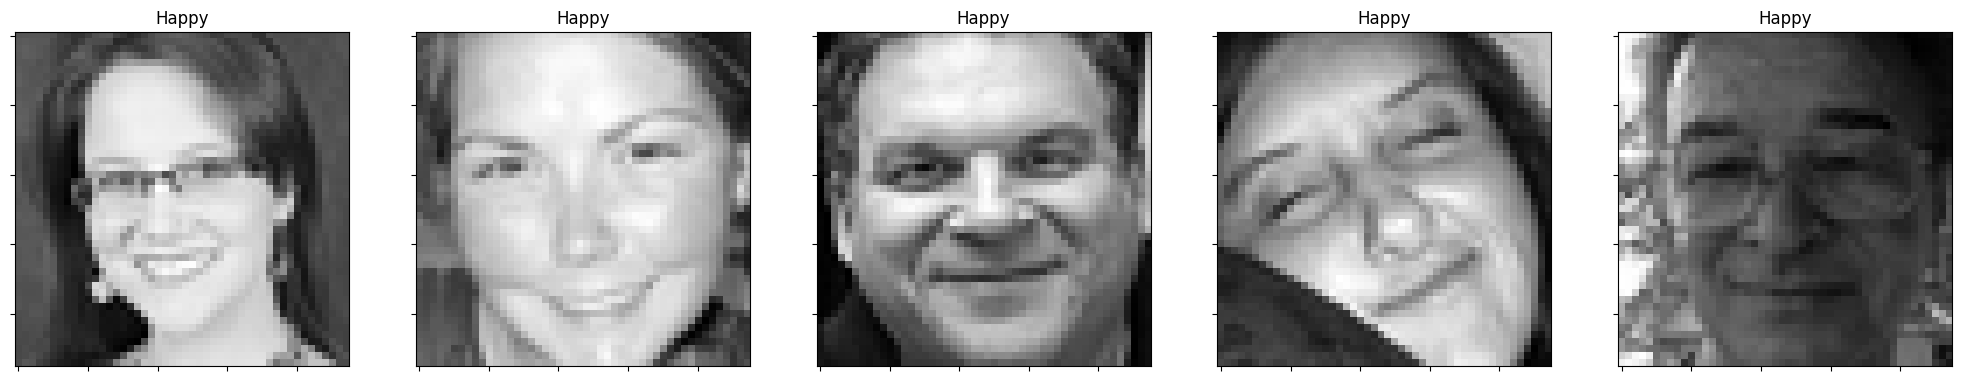

In [ ]:
plot_examples(df, train_images, train_labels, label=3)

- **Sad**

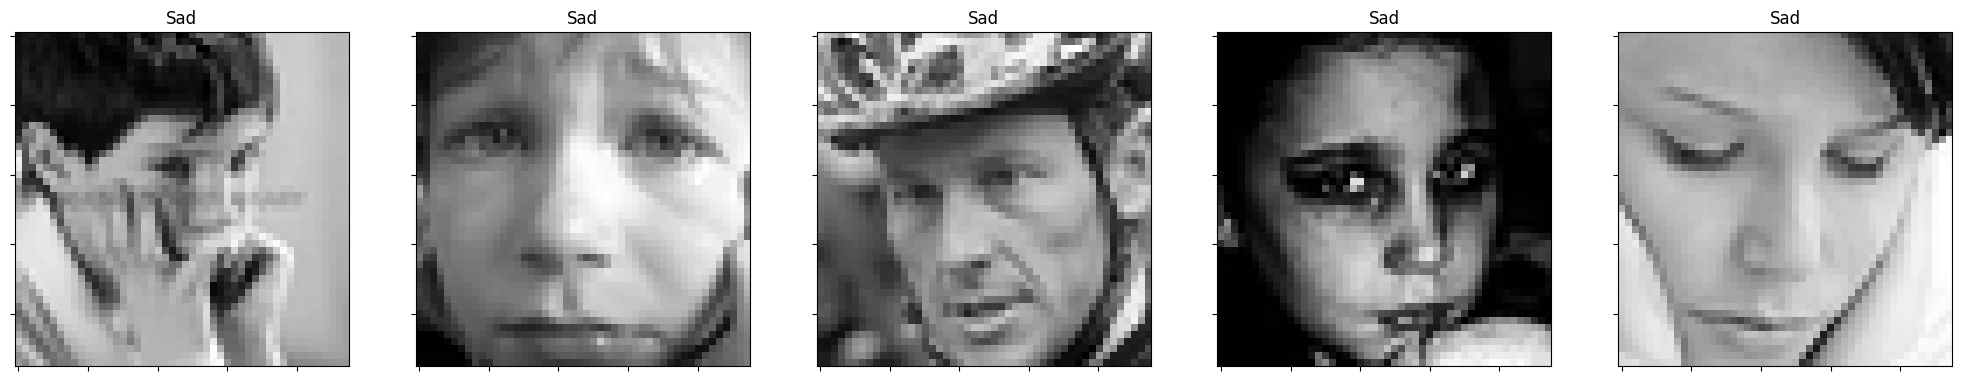

In [ ]:
plot_examples(df, train_images, train_labels, label=4)

- **Surprise**

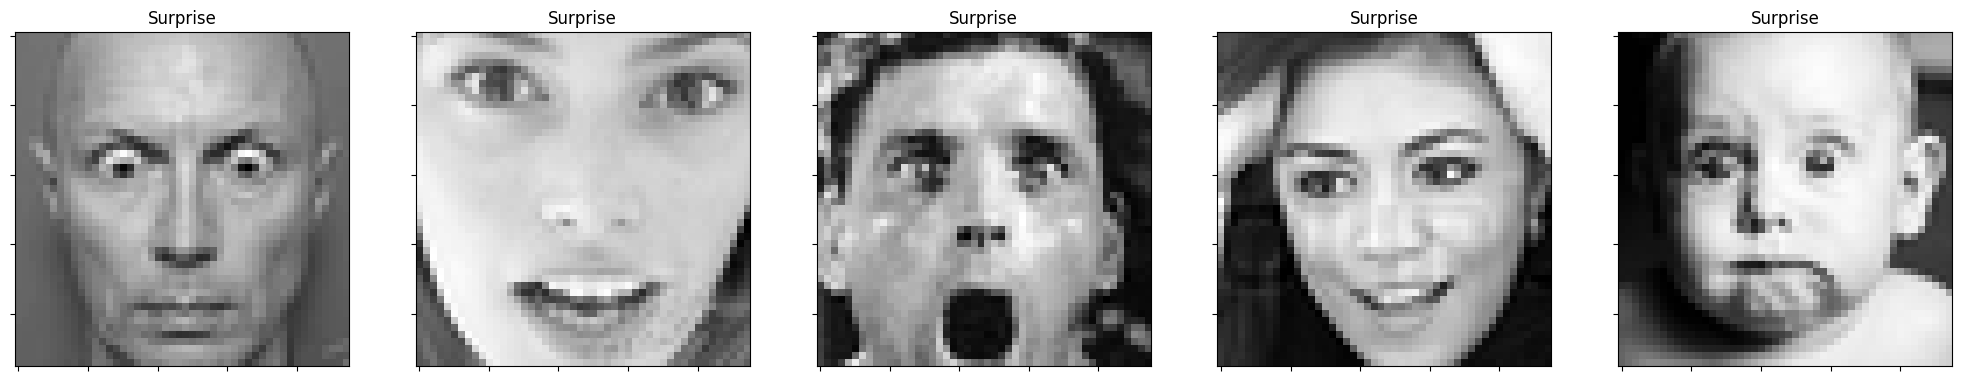

In [ ]:
plot_examples(df, train_images, train_labels, label=5)

- **Neutral**

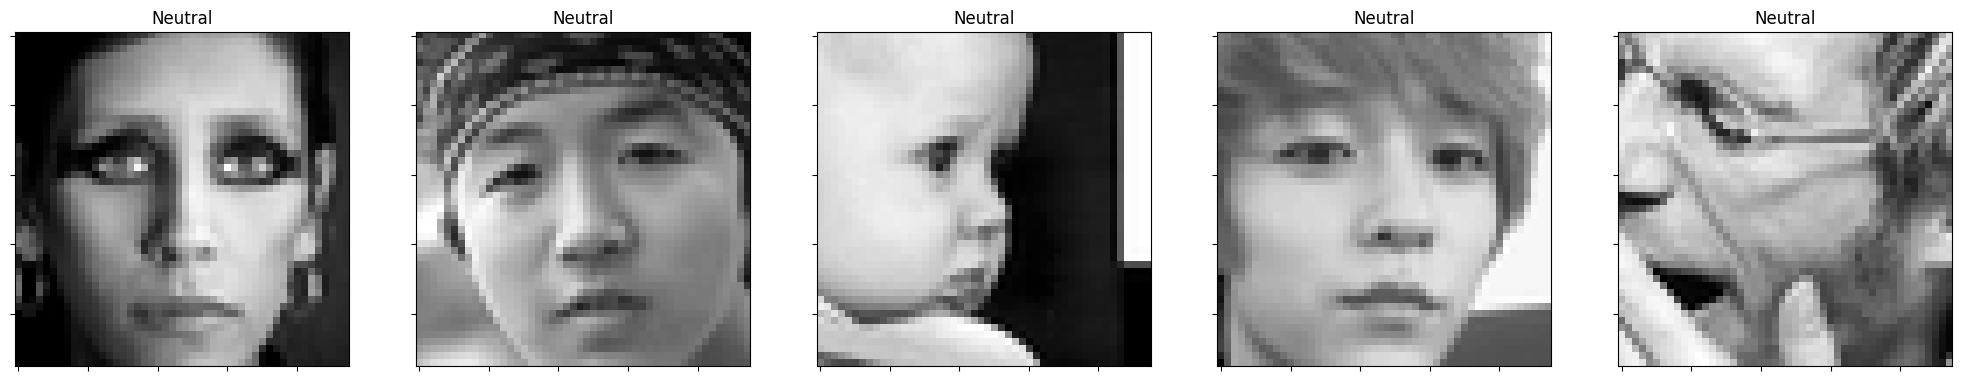

In [ ]:
plot_examples(df, train_images, train_labels, label=6)

**Tổng quan tất cả trường hợp emotion**

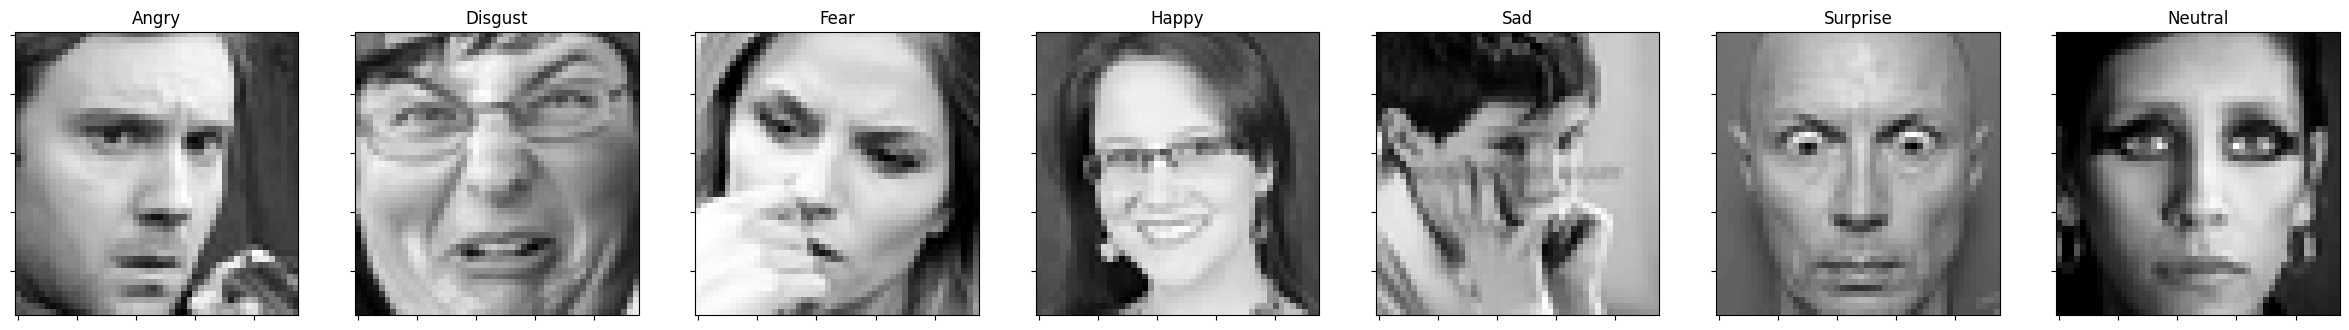

In [ ]:
plot_all_emotions(df, train_images, train_labels)

### **Phân phối nhãn**

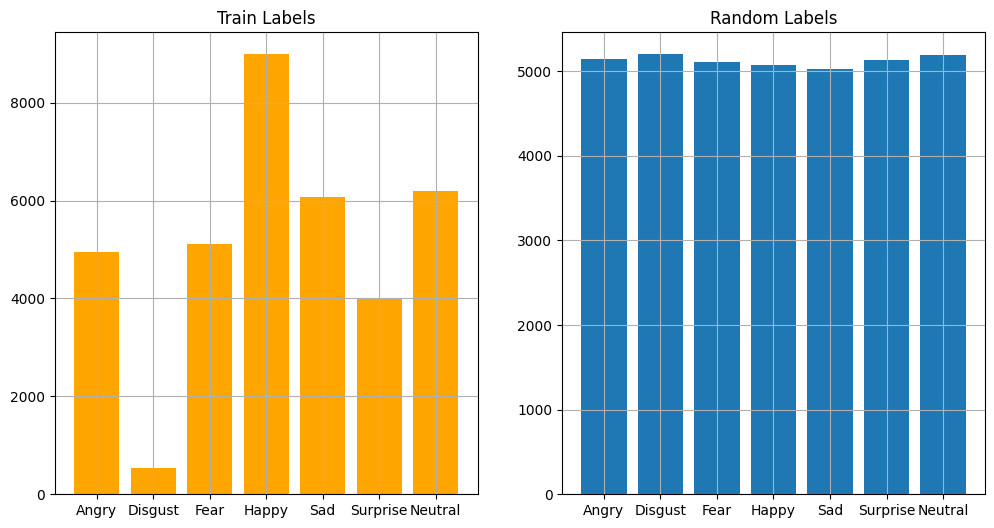

In [ ]:
# Example arrays (using train_labels for demonstration)
array1 = train_labels
array2 = np.random.randint(0, 7, len(train_labels))  # Example of another distribution

plot_compare_distributions(array1, array2, title1='Train Labels', title2='Random Labels')

1. **Train Labels**: ta nhận thấy sự mất cân bằng rõ rệt:
- Nhãn "Happy" xuất hiện nhiều nhất (~8000).
- Nhãn "Disgust" xuất hiện ít nhất (gần 0).
- Nhãn "Fear", "Sad", và "Neutral" trung bình (~5000-7000).
- Nhãn "Angry" và "Surprise" thấp hơn.
2. **Random Labels** có phân phối đồng đều: mọi nhãn có tần suất xuất hiện tương đương (~5000).
3. **So sánh chung**
- **Train Labels**: Mất cân bằng giữa các nhãn.
- **Random Labels**: Phân phối đều đặn.
=> **Kết luận**: Dữ liệu mất cân bằng trong tập huấn luyện bởi vì nhãn "Happy" quá phổ biến có thể gây thiên vị cho mô hình.

## 2. **Principle Component Analysis**

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

**Trực quan tính tuyến tính của dữ liệu**

- **Tổng quan dữ liệu trên không gian hai chiều**

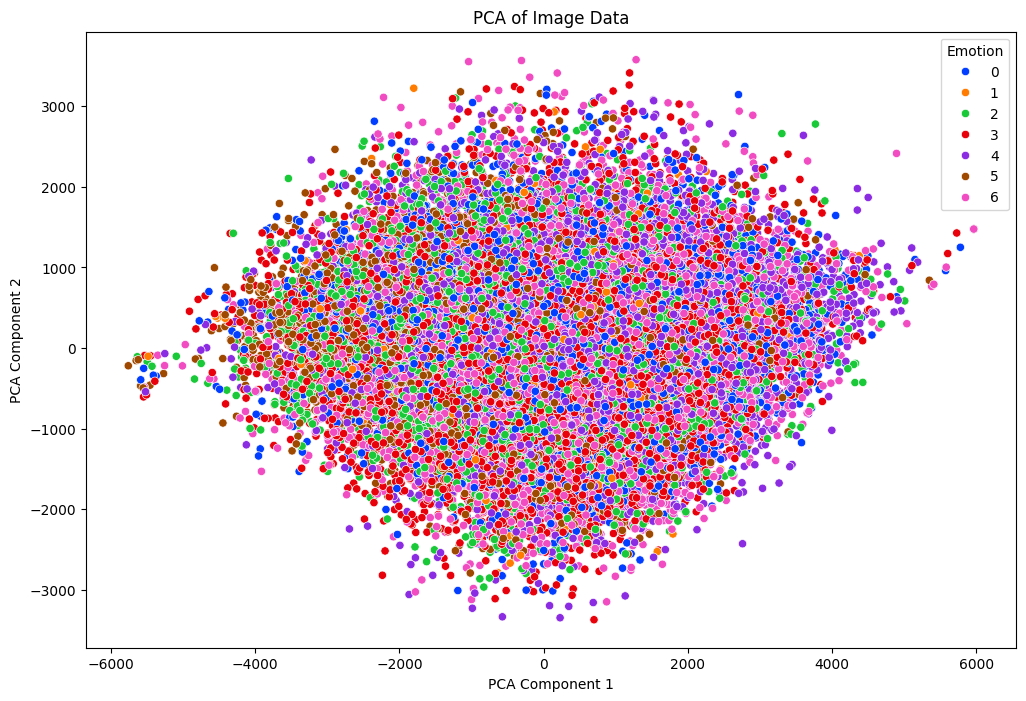

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
# Flatten the images for PCA
flat_images = train_images.reshape(len(train_images), -1)
# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flat_images)

# Plot the PCA result
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=train_labels, palette='bright')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Image Data')
plt.legend(title='Emotion')
plt.show()

**Kết quả sẽ là một biểu đồ phân tán (scatter plot) của các điểm dữ liệu hình ảnh, chiếu lên hai thành phần chính đầu tiên từ PCA. Mỗi điểm dữ liệu đại diện cho một hình ảnh trong bộ dữ liệu và được chiếu lên một không gian 2D.**

**Nhận xét:**  Từ hình ảnh trên có thể thấy chúng ta không thể trực quan dữ liệu trên không gian hai chiều(n_componets = 2) vì không mang lại ý nghĩa nào về mặt trực quan đối với bộ dữ liệu.

- **Trực quan 2 nhãn trong dữ liệu**

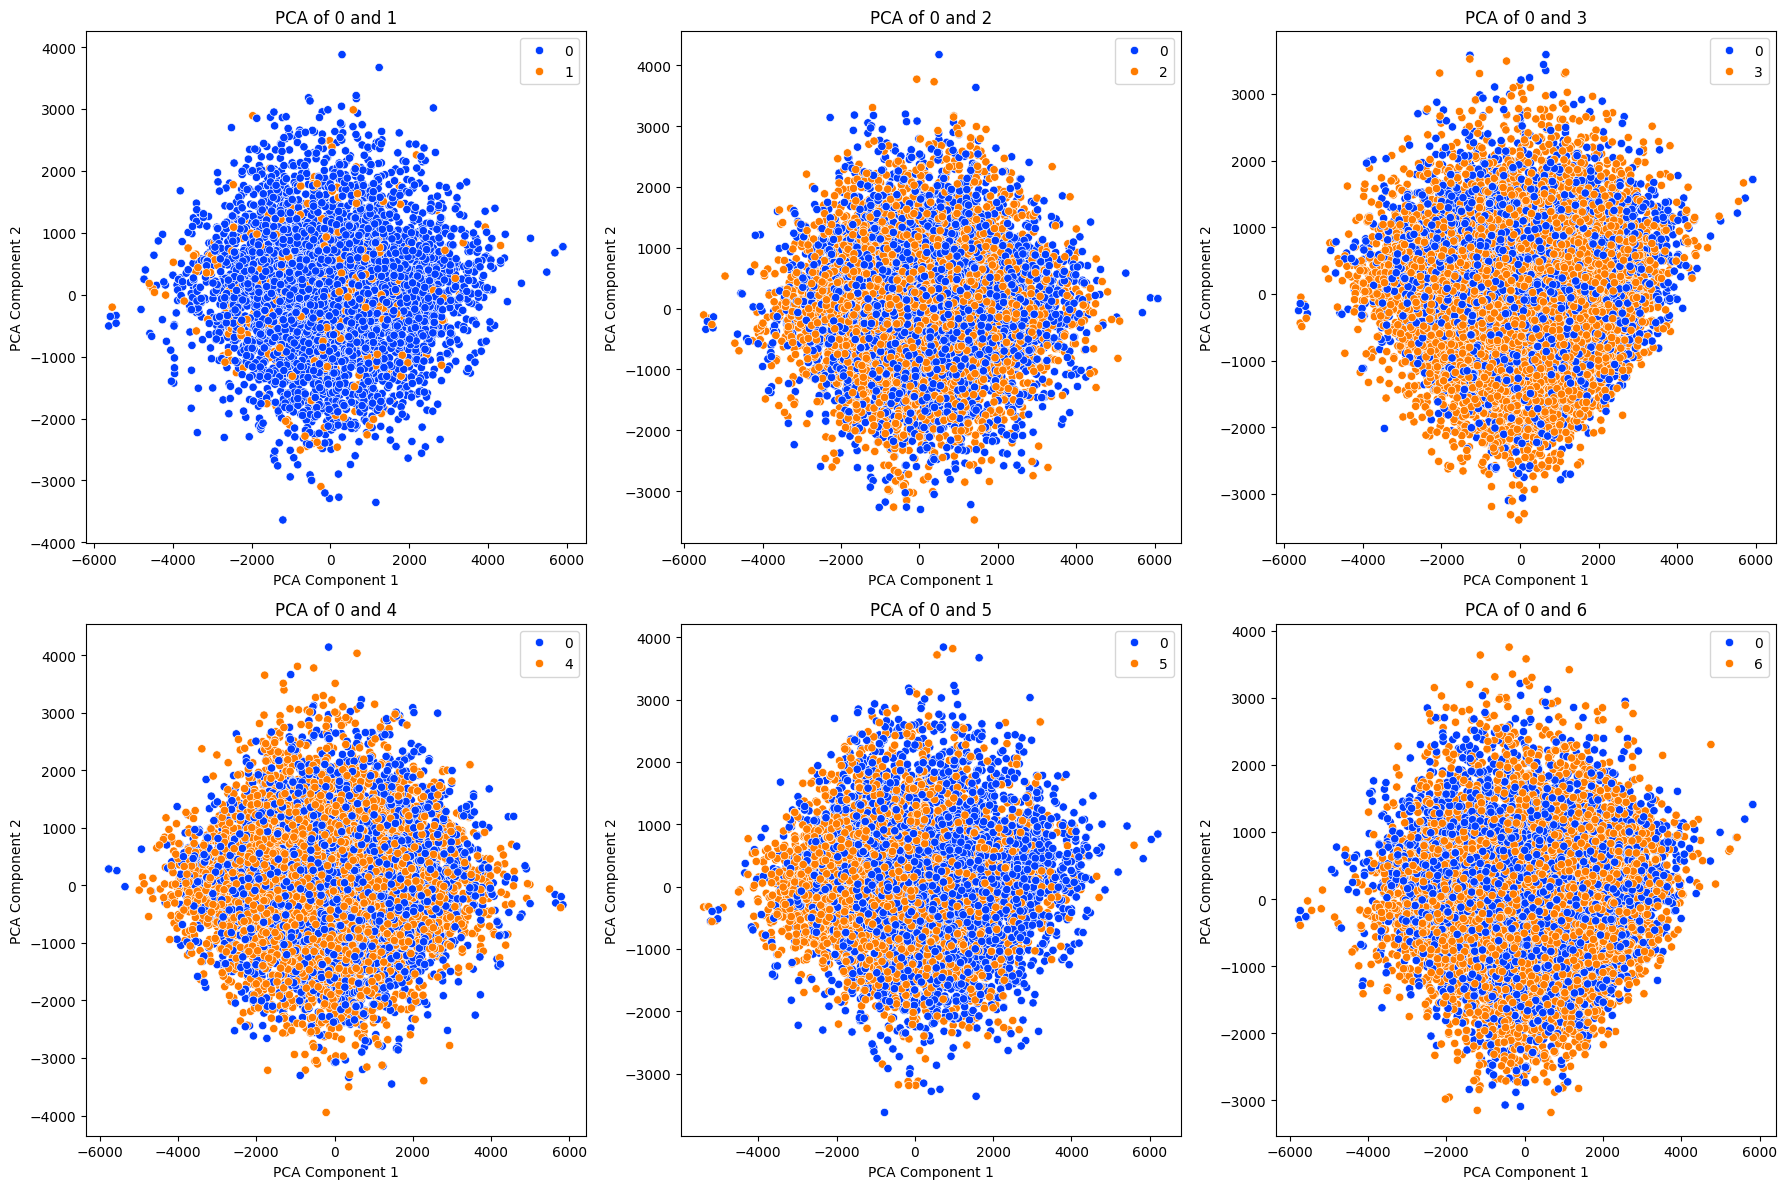

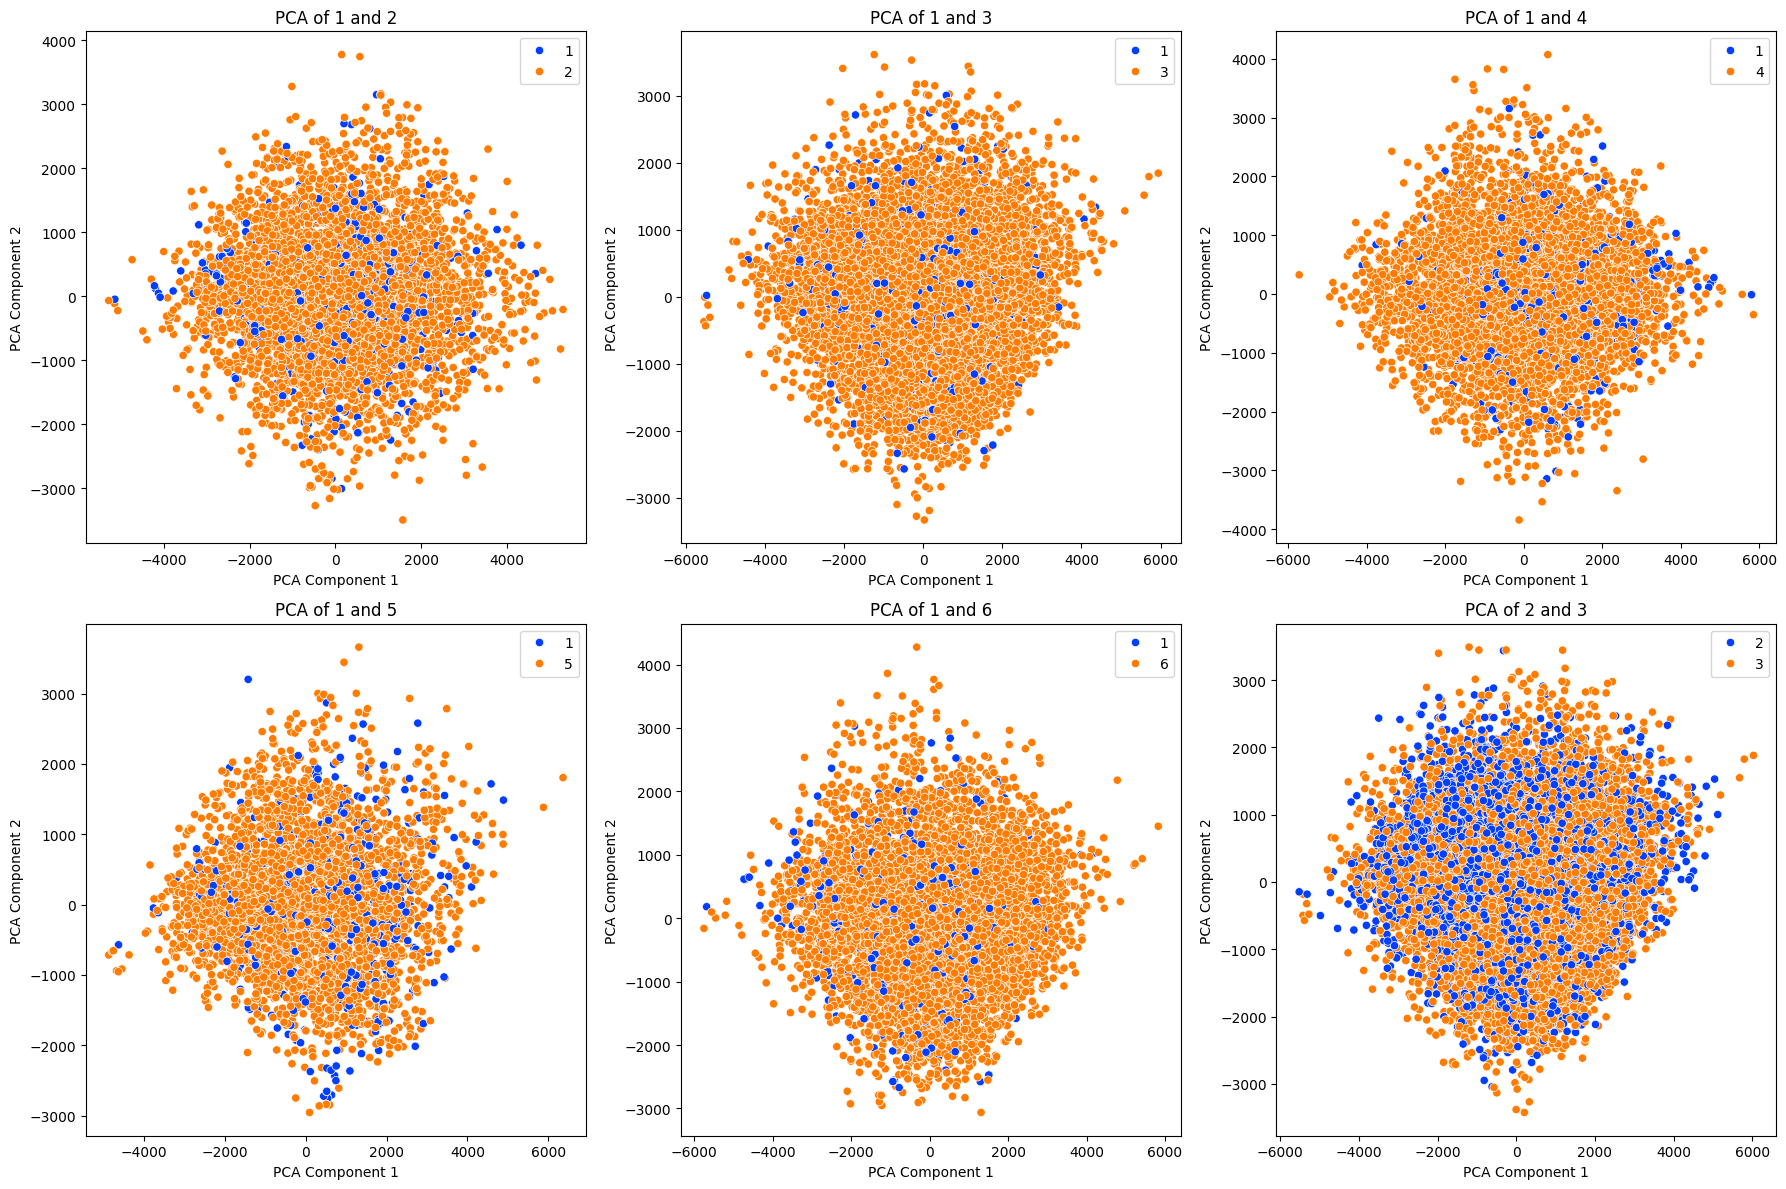

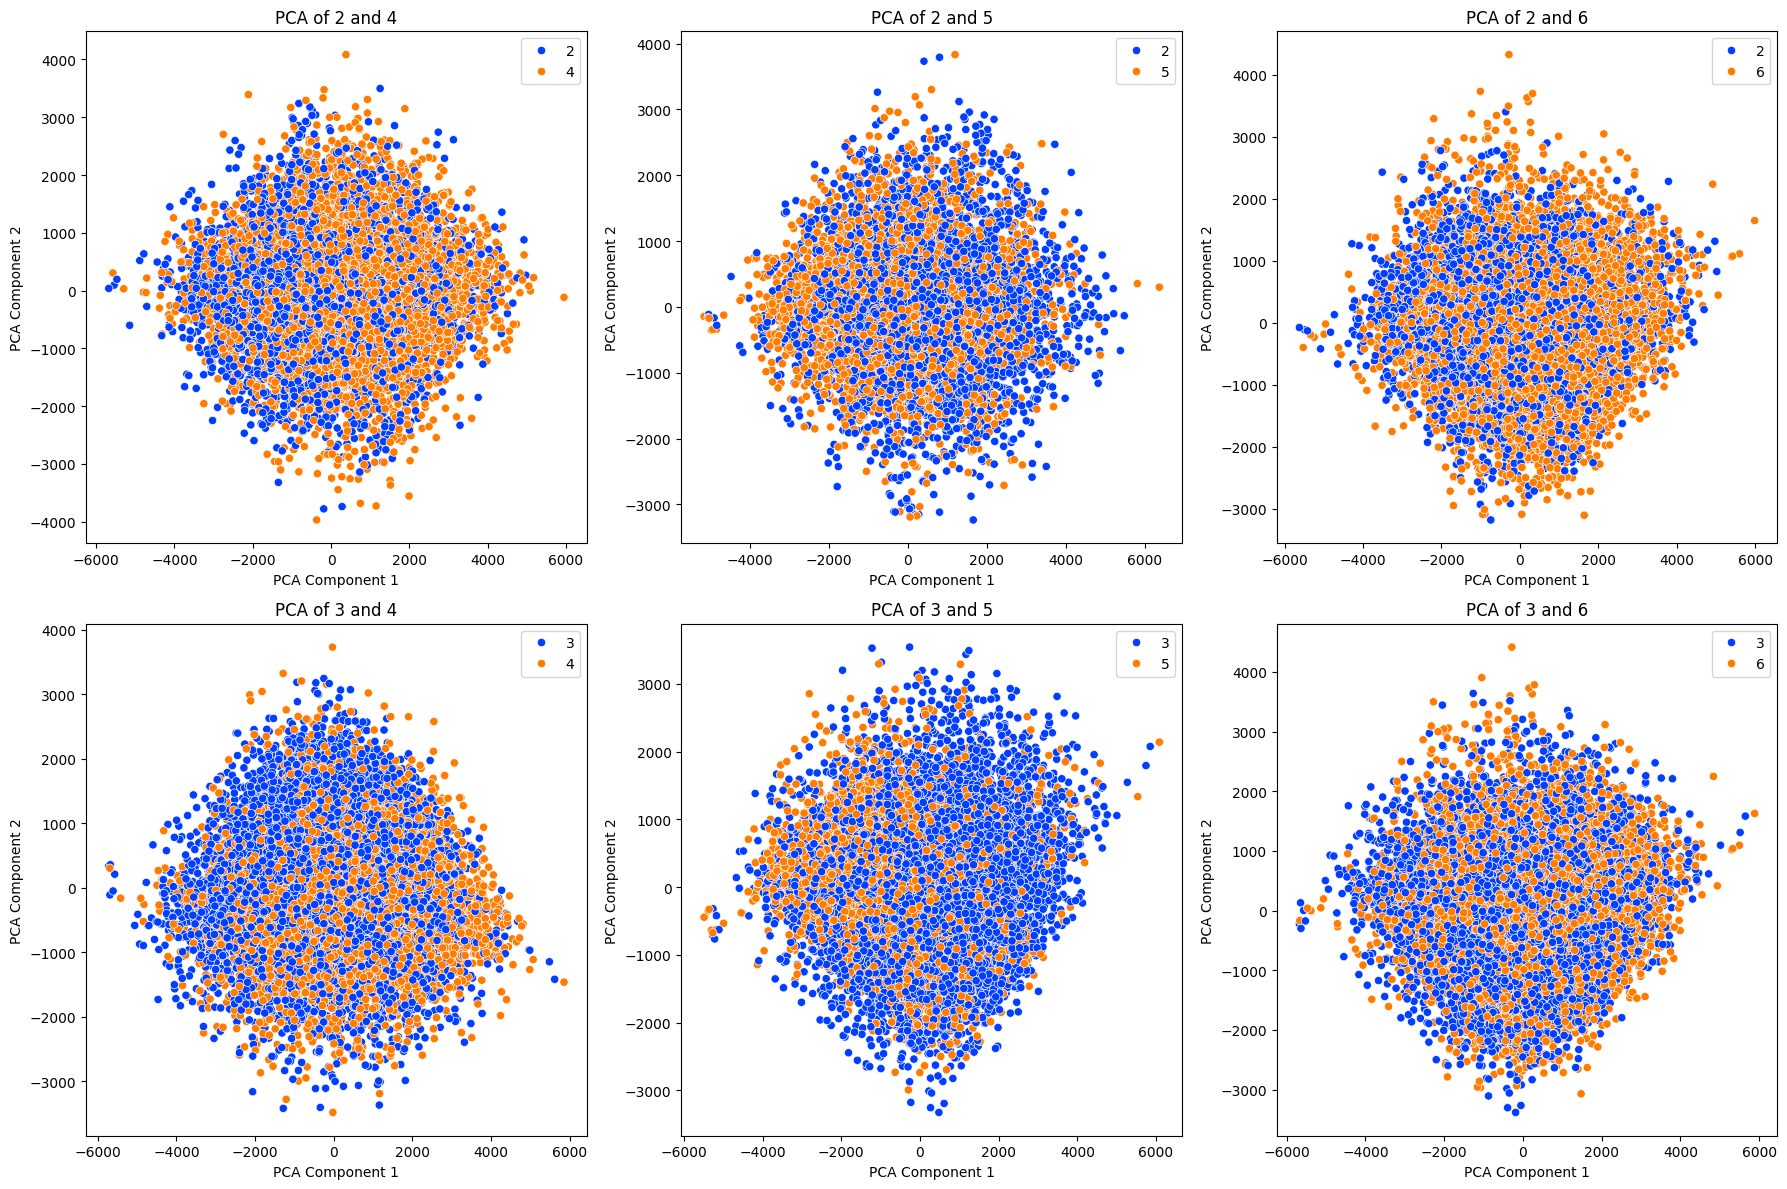

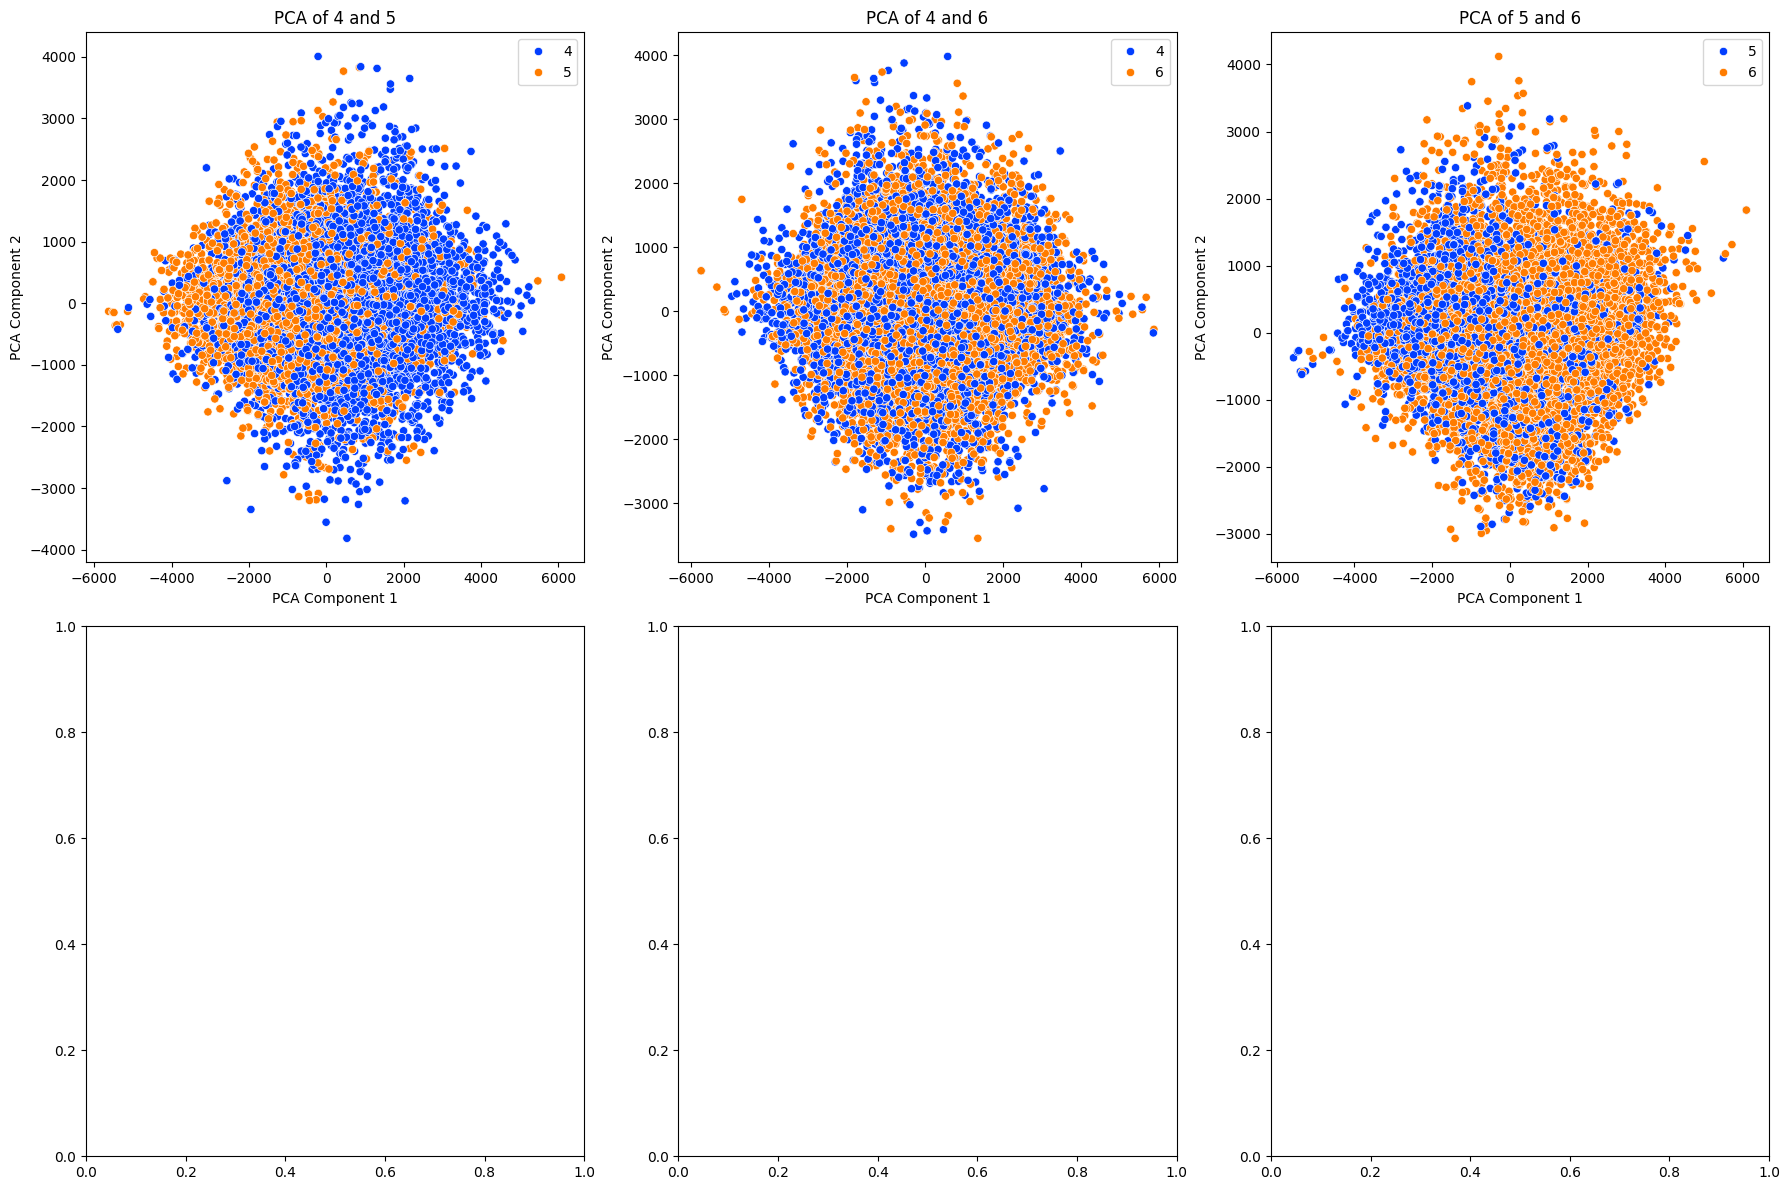

In [ ]:
# Find all unique labels
unique_labels = np.unique(train_labels)

# Create all possible pairs of labels
label_pairs = list(combinations(unique_labels, 2))

# Function to plot PCA for given label pairs
def plot_pca_for_label_pairs(label_pairs, start_idx, num_pairs=6):
    # Initialize the figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    # Loop over label pairs and create PCA plots
    for idx, (label1, label2) in enumerate(label_pairs[start_idx:start_idx + num_pairs]):
        # Filter the images and labels for the two selected labels
        filtered_indices = np.where((train_labels == label1) | (train_labels == label2))
        filtered_images = train_images[filtered_indices]
        filtered_labels = train_labels[filtered_indices]

        # Flatten the images for PCA
        flat_images = filtered_images.reshape(len(filtered_images), -1)

        # Apply PCA
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(flat_images)

        # Plot the PCA result
        sns.scatterplot(ax=axes[idx], x=pca_result[:, 0], y=pca_result[:, 1], hue=filtered_labels, palette='bright')
        axes[idx].set_title(f'PCA of {label1} and {label2}')
        axes[idx].set_xlabel('PCA Component 1')
        axes[idx].set_ylabel('PCA Component 2')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Plot PCA for each set of 6 label pairs
num_pairs_per_plot = 6
for i in range(0, len(label_pairs), num_pairs_per_plot):
    plot_pca_for_label_pairs(label_pairs, i, num_pairs_per_plot)

- **Nhận xét:** Ta có thể thấy rằng hầu hết các nhãn trong các biểu đồ không có sự phân tách tuyến tính rõ ràng giữa hai lớp trong không gian PCA. Các lớp chồng chéo nhau và không dễ dàng phân biệt bằng một đường thẳng.

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

Để xác định số lượng thành phần chính (principal components - PCs) tối ưu, ta cần xem xét tỷ lệ phương sai được giải thích (explained_variance_ratio_) bởi các PCs. Mục tiêu là chọn số lượng PCs sao cho giữ lại được phần lớn phương sai trong dữ liệu ban đầu mà không cần sử dụng quá nhiều PCs, giúp giảm chiều dữ liệu và cải thiện hiệu quả tính toán.
- Các bước thực hiện:
    - **Khởi tạo PCA và tính toán:** Khởi tạo đối tượng PCA và áp dụng nó lên dữ liệu để tính toán các PCs.
    -  **Tính toán phương sai tích lũy**: Sử dụng ```np.cumsum(pca.explained_variance_ratio_)``` để tính toán tỷ lệ phương sai tích lũy được giải thích bởi các PCs.
    - **Vẽ Scree Plot**: Tạo biểu đồ Scree Plot để trực quan hóa tỷ lệ phương sai tích lũy theo số lượng PCs.
    - **Xác định điểm khuỷu (elbow point)**: Sử dụng logic để tìm điểm khuỷu, là điểm mà sau đó tỷ lệ tăng của phương sai giải thích giảm đi đáng kể. Đây thường là dấu hiệu để chọn số lượng PCs tối ưu.

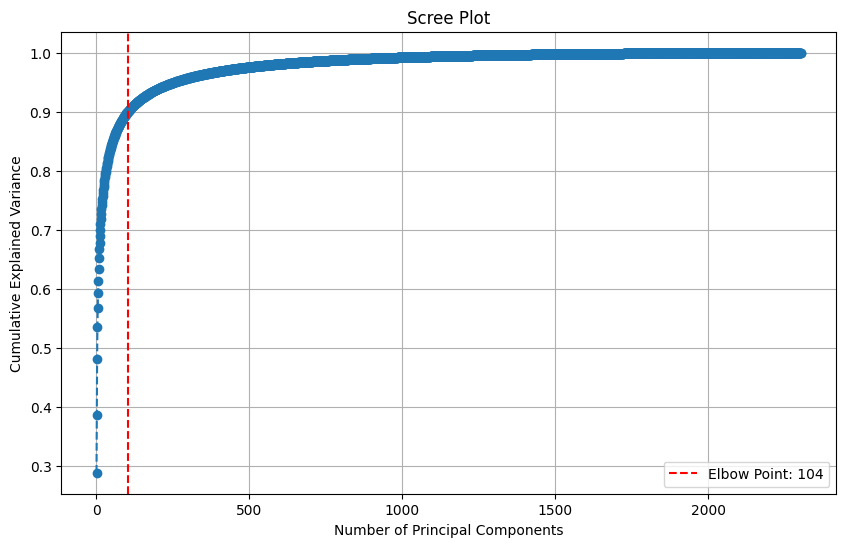

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Khởi tạo PCA và tính toán
pca = PCA()
pca.fit(flat_images)


# Calculate cumulative explained variance
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()

# Add a vertical line at the elbow point (if known)
elbow_point = np.argmax(explained_variance_ratio>= 0.9) + 1 # Example logic for determining the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow Point: {elbow_point}')
plt.legend()

plt.show()

**Nhận xét**: Từ hình ảnh có thể thấy component tối ưu được chọn là **104**. Điều này có nghĩa là 104 PCs đầu tiên giải thích được 90% phương sai của dữ liệu ban đầu.

## **3. Image Classification**

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

**Chia tập dữ liệu thành train và test**

In [ ]:
# Tiền xử lý dữ liệu
X = df['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])
y = df['emotion']
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train_Original, X_test_Original, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Chuyển đổi danh sách các danh sách thành mảng numpy
X_train_Original = np.array([np.array(x) for x in X_train_Original])
X_test_Original = np.array([np.array(x) for x in X_test_Original])

**Biến đổi dữ liệu**

**Data dimensionality reduction by PCA**

In [ ]:
# Biến đổi dữ liệu bằng PCA
pca = PCA(n_components=104)  # Số thành phần chính tối ưu được xác định trước đó ở đây sử dụng 90% phương sai
X_train_pca = pca.fit_transform(X_train_Original) # Áp dụng đối với train data
X_test_pca = pca.transform(X_test_Original) # Áp dụng đối với test data


**Inverse data from pca**

In [ ]:
X_train_restored = pca.inverse_transform(X_train_pca)
X_test_restored = pca.inverse_transform(X_test_pca)

### **Model GradientBoostingClassifier**

Gradient boosting sử dụng một quy trình lặp lại để cập nhật mô hình. Công thức tổng quát cho mô hình ở bước \( m \) là:
$$ F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x) $$

Trong đó:
- $( F_m(x))$là mô hình tại bước \( m \).
- $( F_{m-1}(x))$là mô hình tại bước trước đó.
- $( \nu)$ là tốc độ học (learning rate), một hệ số giảm để điều chỉnh mức độ ảnh hưởng của mỗi cây.
- $( h_m(x))$ là cây quyết định mới được huấn luyện để dự đoán phần dư (residuals) hoặc gradient của hàm mất mát tại bước \( m \).

Quá trình huấn luyện bao gồm các bước sau:
1. Khởi tạo mô hình với một giá trị không đổi:
   $ F_0(x) = \arg\min_\gamma \sum_{i=1}^{N} L(y_i, \gamma) $
   Trong đó, $( L)$ là hàm mất mát và $( y_i)$ là nhãn thực tế.

2. Với mỗi bước $( m = 1)$ đến $M$:\
   a. Tính gradient của hàm mất mát:
   \begin{align}
      g_{im} = \left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)}
   \end{align}
   b. Huấn luyện cây quyết định $h_m(x)$ để dự đoán gradient $g_{im}$.\
   c. Cập nhật mô hình:
      $F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$

Quá trình này tiếp tục cho đến khi số bước \( M \) được hoàn thành hoặc mô hình đạt đến hiệu suất mong muốn.

#### **Apply model trên tập dữ liệu gốc**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100,120,150,200],  # You can add more values
    'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
    'max_features': [12, 24, 48],
}

# Initialize the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=0)

# Perform GridSearchCV
grid_search_GB_original = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model to the training data
grid_search_GB_original.fit(X_train_Original, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_search_GB_original.best_params_)

# Evaluate the best model on the test set
best_gb_original = grid_search_GB_original.best_estimator_
y_pred = best_gb_original.predict(X_test_Original)
accuracy_gb_original = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best Gradient Boosting model: {accuracy_gb_original}")

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END learning_rate=0.05, max_features=24, n_estimators=120; total time= 1.8min
[CV] END learning_rate=0.1, max_features=12, n_estimators=200; total time= 1.6min
[CV] END learning_rate=0.1, max_features=48, n_estimators=120; total time= 3.3min
[CV] END learning_rate=0.25, max_features=48, n_estimators=200; total time= 5.6min
[CV] END learning_rate=0.75, max_features=48, n_estimators=120; total time= 3.4min
[CV] END learning_rate=0.05, max_features=12, n_estimators=120; total time=  57.0s
[CV] END learning_rate=0.05, max_features=48, n_estimators=200; total time= 5.6min
[CV] END learning_rate=0.25, max_features=48, n_estimators=150; total time= 4.2min
[CV] END learning_rate=0.75, max_features=12, n_estimators=200; total time= 1.6min
[CV] END learning_rate=0.75, max_features=48, n_estimators=120; total time= 3.3min
[CV] END learning_rate=0.05, max_features=48, n_estimators=50; total time= 1.4min
[CV] END learning_rate=0.1, 

Ta có thể thấy được tham số tốt nhất được dùng cho model này là:
- Best parameters found:  **{'learning_rate': 0.25, 'max_features': 48, 'n_estimators': 200}**
- Với Accuracy of the best Gradient Boosting model cao nhất là:  0.4098841472356651

#### **Apply trên tập dữ liệu đã chuyển đổi với PCA(n_components = 104)**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100,120,150,200],  # You can add more values
    'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
    'max_features': [12, 24, 48],
}

# Initialize the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=0)

# Perform GridSearchCV
grid_search_GB_pca = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model to the training data
grid_search_GB_pca.fit(X_train_pca, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_search_GB_pca.best_params_)

# Evaluate the best model on the test set
best_gb_pca = grid_search_GB_pca.best_estimator_
y_pred = best_gb_pca.predict(X_test_pca)
accuracy_gb_pca = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best Gradient Boosting model: {accuracy_gb_pca}")

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END learning_rate=0.05, max_features=12, n_estimators=100; total time= 1.6min
[CV] END learning_rate=0.05, max_features=48, n_estimators=150; total time= 9.3min
[CV] END learning_rate=0.25, max_features=24, n_estimators=100; total time= 3.2min
[CV] END learning_rate=0.25, max_features=48, n_estimators=120; total time= 7.4min
[CV] END learning_rate=0.75, max_features=12, n_estimators=100; total time= 1.6min
[CV] END learning_rate=0.75, max_features=12, n_estimators=200; total time= 3.2min
[CV] END learning_rate=0.75, max_features=48, n_estimators=120; total time= 7.5min
[CV] END learning_rate=0.05, max_features=24, n_estimators=50; total time= 1.6min
[CV] END learning_rate=0.05, max_features=48, n_estimators=100; total time= 6.2min
[CV] END learning_rate=0.1, max_features=48, n_estimators=150; total time= 9.3min
[CV] END learning_rate=0.5, max_features=24, n_estimators=100; total time= 3.1min
[CV] END learning_rate=0.5, 

- Best parameters found:  **{'learning_rate': 0.1, 'max_features': 24, 'n_estimators': 200}**
- Accuracy of the best Gradient Boosting model: 0.37879454465464146

#### **Apply trên tập dữ liệu đã inverse về size (48*48)**

In [ ]:
# Khôi phục lại dữ liệu ban đầu từ không gian giảm chiều
X_train_restored = pca.inverse_transform(X_train_pca)
X_test_restored = pca.inverse_transform(X_test_pca)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100,120,150,200],  # You can add more values
    'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
    'max_features': [12, 24, 48],
}

# Initialize the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=0)

# Perform GridSearchCV
grid_search_GB_restored = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model to the training data
grid_search_GB_restored.fit(X_train_restored, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_search_GB_restored.best_params_)

# Evaluate the best model on the test set
best_gb_restored = grid_search_GB_restored.best_estimator_
y_pred = best_gb_restored.predict(X_test_restored)
accuracy_gb_restored = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best Gradient Boosting model: {accuracy_gb_restored}")

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV] END learning_rate=0.05, max_features=12, n_estimators=100; total time= 1.7min
[CV] END learning_rate=0.05, max_features=48, n_estimators=120; total time= 7.7min
[CV] END learning_rate=0.25, max_features=12, n_estimators=100; total time= 1.7min
[CV] END learning_rate=0.25, max_features=24, n_estimators=50; total time= 1.6min
[CV] END learning_rate=0.25, max_features=24, n_estimators=200; total time= 6.5min
[CV] END learning_rate=0.5, max_features=48, n_estimators=50; total time= 3.2min
[CV] END learning_rate=0.75, max_features=12, n_estimators=100; total time= 1.7min
[CV] END learning_rate=0.75, max_features=12, n_estimators=200; total time= 3.4min
[CV] END learning_rate=0.75, max_features=48, n_estimators=120; total time= 7.7min
[CV] END learning_rate=0.05, max_features=24, n_estimators=50; total time= 1.6min
[CV] END learning_rate=0.05, max_features=48, n_estimators=100; total time= 6.5min
[CV] END learning_rate=0.1, m

- Best parameters found: **{'learning_rate': 0.25, 'max_features': 48, 'n_estimators': 200}**
- Accuracy of the best Gradient Boosting model: 0.39917876521484086

#### Nhận xét riêng model

In [ ]:
# Tạo bảng chứa Accuracy
data = {
    'Model_GB': ['Original', 'PCA', 'Restored'],
    'Accuracy': [accuracy_gb_original, accuracy_gb_pca, accuracy_gb_restored]
}
df = pd.DataFrame(data)

df

Model_GB  Accuracy
0  Original  0.409884
1       PCA  0.378795
2  Restored  0.385394

Nhận thấy việc dùng dự liệu Original sẽ có vẽ ổn hơn với dữ liệu đã biến đổi

### **Model XGBoost Classifier**

XGBoost là một thuật toán học máy mạnh mẽ và tối ưu hóa từ phương pháp gradient boosting.

Đặc điểm chính của XGBoost.

**Tối ưu hóa tốc độ và hiệu suất:**
* Tree Pruning: Sử dụng chiến lược cắt tỉa cây (pruning) để tránh overfitting, với kỹ thuật "maximum depth".
* Parallel Processing: Hỗ trợ xử lý song song để tăng tốc độ huấn luyện.
* Cache-aware Access: Tối ưu hóa truy cập bộ nhớ cache để tăng hiệu suất tính toán. \

**Regularization (Điều chỉnh):** \
* XGBoost thêm các thuật ngữ điều chỉnh vào hàm mất mát để tránh overfitting, cụ thể là L1 (lasso) và L2 (ridge) regularization.

**Handling Missing Values:**
* Tự động xử lý các giá trị thiếu (missing values) bằng cách học các con đường tối ưu trong cây quyết định.

**Shrinkage (Learning Rate):**
* Hỗ trợ giảm tốc độ học (learning rate), giúp làm chậm quá trình học và cải thiện khả năng tổng quát hóa của mô hình.

**Early Stopping:**
* XGBoost hỗ trợ dừng sớm khi mô hình không còn cải thiện trên tập kiểm tra, giúp tiết kiệm thời gian và tránh overfitting.

**Cross Validation:**
* Hỗ trợ k-fold cross validation tích hợp để đánh giá mô hình và chọn siêu tham số tối ưu.

#### **Apply model trên tập dữ liệu gốc**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
xgb = XGBClassifier(objective='multi:softmax', num_class=7, tree_method='gpu_hist', gpu_id=1)

grid_search_XGB_original = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)

# Huấn luyện GridSearchCV
grid_search_XGB_original.fit(X_train_Original, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [ ]:
print("Best parameters found: ", grid_search_XGB_original.best_params_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}


In [ ]:
# Evaluate the best model on the test set
best_xgb_original = grid_search_GB_original.best_estimator_
y_pred = best_xgb_original.predict(X_test_Original)
accuracy_xgb_original = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best XGBoosing model: {accuracy_xgb_original}")

Accuracy of the best XGBoosing model: 0.5050153246029535


#### **Apply trên tập dữ liệu đã chuyển đổi với PCA(n_components = 104)**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
xgb = XGBClassifier(objective='multi:softmax', num_class=7, tree_method='gpu_hist', gpu_id=1)

grid_search_XGB_pca = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)

# Huấn luyện GridSearchCV
grid_search_XGB_pca.fit(X_train_pca, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [ ]:
print("Best parameters found: ", grid_search_XGB_pca.best_params_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}


In [ ]:
# Evaluate the best model on the test set
best_xgb_pca = grid_search_XGB_pca.best_estimator_
y_pred = best_xgb_pca.predict(X_test_pca)
accuracy_xgb_pca = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best XGBoosing model: {accuracy_xgb_pca}")

Accuracy of the best XGBoosing model: 0.4555586514349401


#### **Apply trên tập dữ liệu đã inverse về size (48*48)**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
xgb = XGBClassifier(objective='multi:softmax', num_class=7, tree_method='gpu_hist', gpu_id=1)

grid_search_XGB_restored = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)

# Huấn luyện GridSearchCV
grid_search_XGB_restored.fit(X_train_restored, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [ ]:
print("Best parameters found: ", grid_search_XGB_restored.best_params_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}


In [ ]:
# Evaluate the best model on the test set
best_xgb_restored = grid_search_XGB_restored.best_estimator_
y_pred = best_xgb_restored.predict(X_test_restored)
accuracy_xgb_restored = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best XGBoosing model: {accuracy_xgb_restored}")

Accuracy of the best XGBoosing model: 0.5032042351629981


### **Model Logistic Regreesion**

**Logistic Regression** là một trong những thuật toán quan trọng trong học máy, đặc biệt là trong bài toán phân loại. Thuật toán này được sử dụng để dự đoán xác suất của một biến phụ thuộc nhị phân dựa trên các biến độc lập.

**Đặc điểm chính của Logistic Regression**:
- **Loại thuật toán**: Thuật toán học có giám sát (supervised learning).
- **Loại bài toán**: Phân loại nhị phân (binary classification).
- **Đầu ra**: Dự đoán xác suất rơi vào một trong hai lớp (0 hoặc 1).
- **Hàm kích hoạt**: Sigmoid function, đưa đầu ra về một giá trị trong khoảng (0, 1)

**Công thức chính của Logistic Regression:**

Công thức dự đoán của Logistic Regression cho một điểm dữ liệu x là:

$$ \hat{p} = \sigma(\mathbf{w}^T \mathbf{x} + b) $$

Trong đó:

$\hat p$: là xác suất dự đoán.


**$σ$** là hàm sigmoid function: $ \sigma(z) = \frac{1}{1 + e^{-z}} $


**$w$** là vector trọng số.

**$x$** là vector đặc trưng của dữ liệu.

**$b$** là hệ số chặn (bias).






In [ ]:
# Define the logistic regression model and hyperparameter grid
logistic = LogisticRegression()
param_grid = {
    'C': [0.1, 1, 10, 100]
}

# Function to perform GridSearchCV and evaluate the model
def evaluate_model(X_train, y_train, X_test, y_test, param_grid, model):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']

    print(f'Best parameters: {grid_search.best_params_}')
    print(f'Accuracy: {accuracy}')
    print(classification_report(y_test, y_pred))

    return best_model, accuracy

#### **Apply model trên tập dữ liệu gốc**

In [ ]:
# Evaluate the logistic regression model on original data
print("Evaluating logistic regression on original data")
model_LG_original, accuracy_lg_original = evaluate_model(X_train_Original, y_train, X_test_Original, y_test, param_grid, logistic)

Evaluating logistic regression on original data


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'C': 1}
Accuracy: 0.31265581463557707
              precision    recall  f1-score   support

           0       0.21      0.17      0.18       939
           1       0.07      0.03      0.04        99
           2       0.22      0.18      0.20       971
           3       0.43      0.56      0.48      1815
           4       0.23      0.21      0.22      1159
           5       0.30      0.30      0.30       628
           6       0.30      0.30      0.30      1208

    accuracy                           0.31      6819
   macro avg       0.25      0.25      0.25      6819
weighted avg       0.29      0.31      0.30      6819



In [ ]:
# Evaluate the logistic regression model on original data
print("Evaluating logistic regression on original data")
model_LG_original, accuracy_lg_original = evaluate_model(X_train_Original, y_train, X_test_Original, y_test, param_grid, logistic)

Evaluating logistic regression on original data

Best parameters: {'C': 1}
Accuracy: 0.31265581463557707
              precision    recall  f1-score   support

           0       0.21      0.17      0.18       939
           1       0.07      0.03      0.04        99
           2       0.22      0.18      0.20       971
           3       0.43      0.56      0.48      1815
           4       0.23      0.21      0.22      1159
           5       0.30      0.30      0.30       628
           6       0.30      0.30      0.30      1208

    accuracy                           0.31      6819
   macro avg       0.25      0.25      0.25      6819
weighted avg       0.29      0.31      0.30      6819



**Nhận xét**: Accuracy of the best Logistic Regression model with orginal data: 0.31

#### **Apply trên tập dữ liệu đã chuyển đổi với PCA(n_components = 104)**

In [ ]:
# Evaluate the logistic regression model on PCA-transformed data
print("\nEvaluating logistic regression on PCA-transformed data")
model_LG_pca, accuracy_lg_pca = evaluate_model(X_train_pca, y_train, X_test_pca, y_test, param_grid, logistic)


Evaluating logistic regression on PCA-transformed data


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'C': 0.1}
Accuracy: 0.36368969057046485
              precision    recall  f1-score   support

           0       0.30      0.14      0.19       939
           1       0.00      0.00      0.00        99
           2       0.24      0.12      0.16       971
           3       0.43      0.68      0.53      1815
           4       0.28      0.30      0.29      1159
           5       0.42      0.37      0.39       628
           6       0.34      0.34      0.34      1208

    accuracy                           0.36      6819
   macro avg       0.29      0.28      0.27      6819
weighted avg       0.34      0.36      0.34      6819



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

In [ ]:
# Evaluate the logistic regression model on PCA-transformed data
print("\nEvaluating logistic regression on PCA-transformed data")
model_LG_pca, accuracy_lg_pca = evaluate_model(X_train_pca, y_train, X_test_pca, y_test, param_grid, logistic)


Evaluating logistic regression on PCA-transformed data

Best parameters: {'C': 0.1}
Accuracy: 0.36368969057046485
              precision    recall  f1-score   support

           0       0.30      0.14      0.19       939
           1       0.00      0.00      0.00        99
           2       0.24      0.12      0.16       971
           3       0.43      0.68      0.53      1815
           4       0.28      0.30      0.29      1159
           5       0.42      0.37      0.39       628
           6       0.34      0.34      0.34      1208

    accuracy                           0.36      6819
   macro avg       0.29      0.28      0.27      6819
weighted avg       0.34      0.36      0.34      6819



**Nhận xét**: Accuracy of the best Logistic Regression model with PCA data: 0.36

#### **Apply trên tập dữ liệu đã inverse về size (48*48)**

In [ ]:
#Evaluate the logistic regression model on data inverse sau khi PCA
print("\nEvaluating logistic regression on PCA-transformed data inverse")
model_LG_restored, accuracy_lg_restored = evaluate_model(X_train_restored, y_train, X_test_restored, y_test, param_grid, logistic)


Evaluating logistic regression on PCA-transformed data inverse


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best parameters: {'C': 100}
Accuracy: 0.36090335826367503
              precision    recall  f1-score   support

           0       0.29      0.16      0.21       939
           1       0.06      0.02      0.03        99
           2       0.24      0.13      0.17       971
           3       0.44      0.68      0.53      1815
           4       0.27      0.27      0.27      1159
           5       0.43      0.35      0.38       628
           6       0.34      0.35      0.34      1208

    accuracy                           0.36      6819
   macro avg       0.29      0.28      0.28      6819
weighted avg       0.34      0.36      0.34      6819



In [ ]:
#Evaluate the logistic regression model on data inverse sau khi PCA
print("\nEvaluating logistic regression on PCA-transformed data inverse")
model_LG_restored, accuracy_lg_restored = evaluate_model(X_train_restored, y_train, X_test_restored, y_test, param_grid, logistic)


Evaluating logistic regression on PCA-transformed data inverse

Best parameters: {'C': 100}
Accuracy: 0.36090335826367503
              precision    recall  f1-score   support

           0       0.29      0.16      0.21       939
           1       0.06      0.02      0.03        99
           2       0.24      0.13      0.17       971
           3       0.44      0.68      0.53      1815
           4       0.27      0.27      0.27      1159
           5       0.43      0.35      0.38       628
           6       0.34      0.35      0.34      1208

    accuracy                           0.36      6819
   macro avg       0.29      0.28      0.28      6819
weighted avg       0.34      0.36      0.34      6819



**Nhận xét**: Accuracy of the best Logistic Regression model with  PCA-transformed data inverse: 0.36

## **Model SVM**

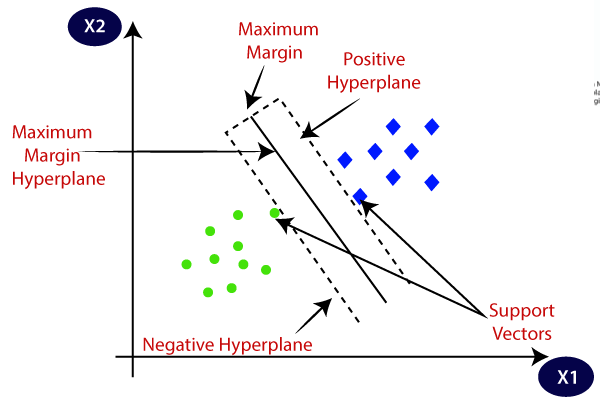

Thuật toán SVM (Support Vector Machine) thực hiện phân lớp dựa trên các nguyên lý toán học nhằm tìm ra siêu phẳng tối ưu để phân chia các điểm dữ liệu của hai lớp. Các bước thực hiện thuật toán SVM:
- **Bước 1: Chuẩn bị dữ liệu**

Cho một tập dữ liệu huấn luyện $(x_i, y_i)$ với $i = 1, \ldots, n$, trong đó $x_i \in \mathbb{R}^d$ là điểm dữ liệu và $y_i \in \{-1, 1\}$ là nhãn lớp.

- **Bước 2: Thiết lập hàm quyết định**

Siêu phẳng có thể được biểu diễn bởi phương trình:
\[ $w\cdot x + b = 0$ \]
trong đó $w$ là vector trọng số và $b$ là hằng số bias.

- **Bước 3: Ràng buộc phân lớp**

Để dữ liệu được phân lớp chính xác, cần thoả mãn:
\[ $y_i (w \cdot x_i + b) \geq 1 \$]
Điều này đảm bảo rằng các điểm thuộc lớp +1 nằm một phía của siêu phẳng và các điểm thuộc lớp -1 nằm phía bên kia.

- **Bước 4: Hàm mục tiêu**

Mục tiêu là tối đa hóa khoảng cách giữa các điểm dữ liệu và siêu phẳng. Điều này tương đương với việc tối thiểu hóa:
\[ $\frac{1}{2} \| w \|^2 $\]
dưới các ràng buộc:
\[ $y_i (w \cdot x_i + b) \geq 1$ \]

- **Bước 5: Bài toán tối ưu hóa**

Đây là bài toán tối ưu hóa bậc hai với các ràng buộc tuyến tính, có thể được viết lại dưới dạng:
\[ $\min_{w,b} \frac{1}{2} \| w \|^2 $\]
\[ $\text{subject to } y_i (w \cdot x_i + b) \geq 1, \; i = 1, \ldots, n$ \]

- **Bước 6: Sử dụng phương pháp Lagrange**

Để giải bài toán này, ta sử dụng phương pháp nhân tử Lagrange:
\[ $L(w, b, \alpha) = \frac{1}{2} \| w \|^2 - \sum_{i=1}^n \alpha_i [y_i (w \cdot x_i + b) - 1]$ \]
trong đó $\alpha_i \geq 0$ là các nhân tử Lagrange.

- **Bước 7: Tìm nghiệm tối ưu**

Để tìm nghiệm của $L(w, b, \alpha)$, ta cần tối thiểu hóa $L$ theo $w$ và $b$ và tối đa hóa theo $\alpha$. Điều này dẫn đến hệ phương trình:
\[ $\frac{\partial L}{\partial w} = 0 \Rightarrow w = \sum_{i=1}^n \alpha_i y_i x_i$ \]
\[ $\frac{\partial L}{\partial b} = 0 \Rightarrow \sum_{i=1}^n \alpha_i y_i = 0 $\]

- **Bước 8: Dual Problem**

Bằng cách thay thế $w$ và $b$ vào $L$, ta có bài toán tối ưu kép:
\[ $\max_{\alpha} \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n \alpha_i \alpha_j y_i y_j (x_i \cdot x_j) $\]
\[ $\text{subject to } \sum_{i=1}^n \alpha_i y_i = 0$ \]
\[ $\alpha_i \geq 0, \; i = 1, \ldots, n$ \]

- **Bước 9: Kernel Trick (Nếu cần)**

Nếu dữ liệu không tuyến tính, ta có thể sử dụng kernel trick để chuyển dữ liệu vào không gian đặc trưng cao hơn:
\[$ K(x_i, x_j) = \phi(x_i) \cdot \phi(x_j) $\]
trong đó $\phi$ là hàm ánh xạ vào không gian đặc trưng.

- **Bước 10: Xác định siêu phẳng và hàm quyết định**

Sau khi giải quyết được bài toán tối ưu, vector trọng số $w$ và hằng số bias $b$ có thể được sử dụng để xác định hàm quyết định:
\[ $f(x) = w \cdot x + b$ \]
Dự đoán lớp của điểm dữ liệu mới $x$ dựa trên dấu của $f(x)$:
\[ $\text{class}(x) = \text{sign}(f(x)) $\]


**Gridsearch để tìm hyparameter tốt nhất cho model**

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Hyparameter
param_grid = {
    'svm__C': [10, 100, 1000],
    'svm__gamma': ['scale', 'auto']
}

# GridSearchCV để tìm siêu tham số tốt nhất
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=1,  verbose=3)
grid_search.fit(X_train_pca, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))



Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END .......svm__C=10, svm__gamma=scale;, score=0.453 total time= 4.2min
[CV 2/3] END .......svm__C=10, svm__gamma=scale;, score=0.462 total time= 4.2min
[CV 3/3] END .......svm__C=10, svm__gamma=scale;, score=0.454 total time= 3.9min
[CV 1/3] END ........svm__C=10, svm__gamma=auto;, score=0.453 total time= 3.9min
[CV 2/3] END ........svm__C=10, svm__gamma=auto;, score=0.462 total time= 3.9min
[CV 3/3] END ........svm__C=10, svm__gamma=auto;, score=0.454 total time= 4.2min
[CV 1/3] END ......svm__C=100, svm__gamma=scale;, score=0.445 total time= 4.7min
[CV 2/3] END ......svm__C=100, svm__gamma=scale;, score=0.456 total time= 4.1min
[CV 3/3] END ......svm__C=100, svm__gamma=scale;, score=0.445 total time= 4.2min
[CV 1/3] END .......svm__C=100, svm__gamma=auto;, score=0.445 total time= 4.2min
[CV 2/3] END .......svm__C=100, svm__gamma=auto;, score=0.456 total time= 4.4min
[CV 3/3] END .......svm__C=100, svm__gamma=auto;,

#### **Apply model trên tập dữ liệu gốc**

In [ ]:
model_svm_original = SVC(C=10, gamma='scale', kernel='rbf')  # SVM model với các tham số tốt nhất, add name 'svm'
# Huấn luyện mô hình SVM
model_svm_original.fit(X_train_Original, y_train)

In [ ]:
# Dự đoán trên tập test
y_pred = model_svm_original.predict(X_test_Original)

# Đánh giá độ chính xác của mô hình
accuracy_svm_original = accuracy_score(y_test, y_pred)

# In kết quả dự đoán và độ chính xác
print("Accuracy:", accuracy_svm_original)

Accuracy: 0.4754806352744497


#### **Apply trên tập dữ liệu đã chuyển đổi với PCA(n_components = 104)**

In [ ]:
model_svm_pca = SVC(C=10, gamma='scale', kernel='rbf')  # SVM model với các tham số tốt nhất, add name 'svm'
# Huấn luyện mô hình SVM
model_svm_pca.fit(X_train_pca, y_train)

In [ ]:
# Dự đoán trên tập test
y_pred = model_svm_pca.predict(X_test_pca)

# Đánh giá độ chính xác của mô hình
accuracy_svm_pca = accuracy_score(y_test, y_pred)

# In kết quả dự đoán và độ chính xác
print("Accuracy:", accuracy_svm_pca)

Accuracy: 0.4660072443577598


#### **Apply trên tập dữ liệu đã inverse về size (48*48)**

In [ ]:
model_svm_restored = SVC(C=10, gamma='scale', kernel='rbf')  # SVM model với các tham số tốt nhất, add name 'svm'
# Huấn luyện mô hình SVM
model_svm_restored.fit(X_train_restored, y_train)

In [ ]:
# Dự đoán trên tập test
y_pred = model_svm_restored.predict(X_test_restored)

# Đánh giá độ chính xác của mô hình
accuracy_svm_restored = accuracy_score(y_test, y_pred)

# In kết quả dự đoán và độ chính xác
print("Accuracy:", accuracy_svm_restored)

Accuracy: 0.4863471719141822


## **Model Multi-layer Perceptron classifier**

Perception một mô hình có một lớp neuron duy nhất và là dạng mạng neuron đơn giản nhất của artificial neuron (tế bào thần kinh nhân tạo). \\
Multi-layer Perceptron (MLP) là mạng neural network đơn giản được tạo ra từ các liên kết giữa các perceptron. Chúng bao gồm một lớp đầu vào, một hoặc nhiều lớp ẩn và một lớp đầu ra. \\
Là mảng xử lý dữ liệu một chiều, từ lớp đầu vào đến lớp đầu ra. Mỗi nút trong cùng một lớp được kết nói với tất cả các nút trong lớp tiếp theo.

<img src="https://vitalflux.com/wp-content/uploads/2023/02/Sklearn-Neural-Network-MLPRegressor-Regression-Model--300x166.png" alt="Beautiful Landscape" width="450">


Cấu trúc một neuron.
* Một neuron sẽ được một hoặc nhiều đầu vào x<sub>i</sub>. Các đầu vào đóng vai
trò như các sợi nhánh thần kinh (dendrites) nhận tính hiệu từ các
neuron khác.
* Các giá trị đầu vào x<sub>i</sub> được điều phối tầm ảnh hưởng bởi các trọng số tương ứng w<sub>i</sub> của nó, thể hiện mức độ quan trọng (độ mạnh) của dữ liệu đầu vào đối với quá trình xử lí thông tin (quá trình chuyển đổi dữ liệu từ nút này sang nút
khác).
* Tại mỗi nút, chúng ta sẽ biến đổi những dữ liệu đầu vào này bằng
cách tính tổng các giá trị đầu vào với trọng số liên kết tương ứng trên
các đầu vào.
* Giá trị độ lệch (bias).
Ngoài các trọng số, một thành phần khác được áp dụng cho thông
tin đầu vào, được gọi là giá trị đầu vào (bias). Nó được thêm vào kết quả của phép nhân trọng số với giá trị đầu vào.
Bởi vì kết quả của phép nhân luôn là một hàm tuyến tính đi qua gốc
tọa độ nên việc sử dụng bias giúp mạng neuron có thể dịch chuyển
hàm tuyến tính này một cách linh hoạt hơn để mô hình khớp với dữ
liệu được huấn luyện.
* Hàm kích hoạt (Activation function)
Là một thành phần rất quan trọng trong mô hình mạng neuron. Nó
quyết định khi nào một neuron được kích hoạt hay không được kích
hoạt. Liệu thông tin mà neuron nhận được có liên quan đến thông tin
được đưa ra hay nên bỏ qua dựa trên kết quả tổng hợp các tín hiệu
đầu vào mà nó nhận được từ các neuron trước đó.
Nếu không có hàm kích hoạt thì trọng số liên kết và bias chỉ đơn giản
như 1 hàm biến đổi tuyến tính. Giải 1 hàm tuyến tính sẽ đơn giản hơn
nhiều nhưng sẽ khó có thể mô hình hóa và giải được những vấn đề
phức tạp.

<img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*sPg-0hha7o3iNPjY4n-vow.jpeg" alt="Beautiful Landscape" width="450">


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(1024,), (1024, 512), (1024, 512, 256), (1024, 512, 256, 128)],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001]
}
mlp = MLPClassifier(solver='adam', max_iter=200, activation = 'relu', random_state=42, early_stopping=True, n_iter_no_change=10)

# Khởi tạo GridSearchCV
grid_search_MLP = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)

# Huấn luyện GridSearchCV
grid_search_MLP.fit(X_train_Original, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


In [ ]:
print("Best parameters found: ", grid_search_MLP.best_params_)

Best parameters found:  {'alpha': 0.0001, 'hidden_layer_sizes': (1024, 512, 256, 128), 'learning_rate_init': 0.001}


#### **Apply model trên tập dữ liệu gốc**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Xây dựng mô hình MLP
mlp_original = MLPClassifier(hidden_layer_sizes=(2048, 1024, 512, 256, 128),
                    activation='relu',
                    solver='adam',
                    alpha=0.0001,
                    batch_size='auto',
                    learning_rate='adaptive',
                    learning_rate_init=0.001,
                    max_iter=200,
                    shuffle=True,
                    random_state=42,
                    tol=0.0001,
                    verbose=True,
                    early_stopping=True,
                    n_iter_no_change=10)

# Huấn luyện mô hình
mlp_original.fit(X_train_Original, y_train)

Iteration 1, loss = 2.69373998
Validation score: 0.098920
Iteration 2, loss = 2.44879825
Validation score: 0.102752
Iteration 3, loss = 2.36413429
Validation score: 0.131661
Iteration 4, loss = 2.29749253
Validation score: 0.177987
Iteration 5, loss = 2.23900141
Validation score: 0.155347
Iteration 6, loss = 2.17851810
Validation score: 0.224660
Iteration 7, loss = 2.11651558
Validation score: 0.201324
Iteration 8, loss = 2.06043505
Validation score: 0.212818
Iteration 9, loss = 1.98891219
Validation score: 0.210031
Iteration 10, loss = 1.92245084
Validation score: 0.250087
Iteration 11, loss = 1.85225706
Validation score: 0.292233
Iteration 12, loss = 1.76458021
Validation score: 0.326715
Iteration 13, loss = 1.68856080
Validation score: 0.336120
Iteration 14, loss = 1.60850419
Validation score: 0.296761
Iteration 15, loss = 1.53294327
Validation score: 0.309300
Iteration 16, loss = 1.42541017
Validation score: 0.308255
Iteration 17, loss = 1.36599443
Validation score: 0.344479
Iterat

In [ ]:
# Dự đoán trên tập kiểm tra
y_pred = mlp_original.predict(X_test_Original)
# Đánh giá mô hình
accuracy_mlp_original = accuracy_score(y_test, y_pred)
print('Test accuracy:', accuracy_mlp_original)

Test accuracy: 0.4653106714962385


#### **Apply trên tập dữ liệu đã chuyển đổi với PCA(n_components = 104)**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Xây dựng mô hình MLP
mlp_pca = MLPClassifier(hidden_layer_sizes=(2048, 1024, 512, 256, 128),
                    activation='relu',
                    solver='adam',
                    alpha=0.0001,
                    batch_size='auto',
                    learning_rate='adaptive',
                    learning_rate_init=0.001,
                    max_iter=200,
                    shuffle=True,
                    random_state=42,
                    tol=0.0001,
                    verbose=True,
                    early_stopping=True,
                    n_iter_no_change=10)

# Huấn luyện mô hình
mlp_pca.fit(X_train_pca, y_train)

Iteration 1, loss = 1.67766982
Validation score: 0.380704
Iteration 2, loss = 1.50511226
Validation score: 0.407524
Iteration 3, loss = 1.38341885
Validation score: 0.414141
Iteration 4, loss = 1.25457757
Validation score: 0.436085
Iteration 5, loss = 1.13066619
Validation score: 0.435737
Iteration 6, loss = 0.99657797
Validation score: 0.409613
Iteration 7, loss = 0.85405731
Validation score: 0.432254
Iteration 8, loss = 0.72338997
Validation score: 0.427726
Iteration 9, loss = 0.59556864
Validation score: 0.419714
Iteration 10, loss = 0.47149087
Validation score: 0.429815
Iteration 11, loss = 0.36168350
Validation score: 0.419714
Iteration 12, loss = 0.28421080
Validation score: 0.432950
Iteration 13, loss = 0.23605593
Validation score: 0.430512
Iteration 14, loss = 0.19791809
Validation score: 0.413793
Iteration 15, loss = 0.17872607
Validation score: 0.421456
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [ ]:
# Dự đoán trên tập kiểm tra
y_pred = mlp_pca.predict(X_test_pca)
# Đánh giá mô hình
accuracy_mlp_pca = accuracy_score(y_test, y_pred)
print('Test accuracy:', accuracy_mlp_pca)

Test accuracy: 0.43981610476455835


#### **Apply trên tập dữ liệu đã inverse về size (48*48)**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Xây dựng mô hình MLP
mlp_restored = MLPClassifier(hidden_layer_sizes=(2048, 1024, 512, 256, 128),
                    activation='relu',
                    solver='adam',
                    alpha=0.0001,
                    batch_size='auto',
                    learning_rate='adaptive',
                    learning_rate_init=0.001,
                    max_iter=200,
                    shuffle=True,
                    random_state=42,
                    tol=0.0001,
                    verbose=True,
                    early_stopping=True,
                    n_iter_no_change=10)

# Huấn luyện mô hình
mlp_restored.fit(X_train_restored, y_train)

Iteration 1, loss = 2.68988827
Validation score: 0.054336
Iteration 2, loss = 2.45332954
Validation score: 0.123302
Iteration 3, loss = 2.34845214
Validation score: 0.130617
Iteration 4, loss = 2.27385963
Validation score: 0.177987
Iteration 5, loss = 2.20475955
Validation score: 0.187043
Iteration 6, loss = 2.12815430
Validation score: 0.195402
Iteration 7, loss = 2.05470089
Validation score: 0.224312
Iteration 8, loss = 1.97542495
Validation score: 0.207593
Iteration 9, loss = 1.89482778
Validation score: 0.243469
Iteration 10, loss = 1.81213137
Validation score: 0.270637
Iteration 11, loss = 1.74003233
Validation score: 0.270637
Iteration 12, loss = 1.64731937
Validation score: 0.272727
Iteration 13, loss = 1.58291729
Validation score: 0.306513
Iteration 14, loss = 1.49977001
Validation score: 0.297806
Iteration 15, loss = 1.42928963
Validation score: 0.316266
Iteration 16, loss = 1.35660688
Validation score: 0.334378
Iteration 17, loss = 1.27146377
Validation score: 0.311738
Iterat

In [ ]:
# Dự đoán trên tập kiểm tra
y_pred_restored = mlp_pca.predict(X_test_restored)
# Đánh giá mô hình
accuracy_mlp_restored = accuracy_score(y_test, y_pred)
print('Test accuracy:', accuracy_mlp_restored)

Test accuracy: 0.4580663137364168


## **4. Evaluating Classification Performance**

**Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)**



In [ ]:
# Các giá trị độ chính xác
data = {
    'Data Type': ['Original', 'PCA', 'Restored'],
    'Gradient Boosting': [accuracy_gb_original, accuracy_gb_pca, accuracy_gb_restored],
    'Logistic Regression': [accuracy_lg_original, accuracy_mlp_pca, accuracy_mlp_restored],
    'XGBoost': [accuracy_xgb_original, accuracy_xgb_pca, accuracy_xgb_restored],
    'MLP': [accuracy_mlp_original, accuracy_lg_pca, accuracy_lg_restored],
    'SVM': [accuracy_svm_original, accuracy_svm_pca, accuracy_mlp_restored]
}

# Tạo DataFrame
df = pd.DataFrame(data)

df

Data Type  Gradient Boosting  Logistic Regression   XGBoost       MLP  \
0  Original           0.409884                 0.31  0.505015  0.465311   
1       PCA           0.378795                 0.36  0.455559  0.439816   
2  Restored           0.385394                 0.36  0.503204  0.458066   

        SVM  
0  0.475481  
1  0.466007  
2  0.486347

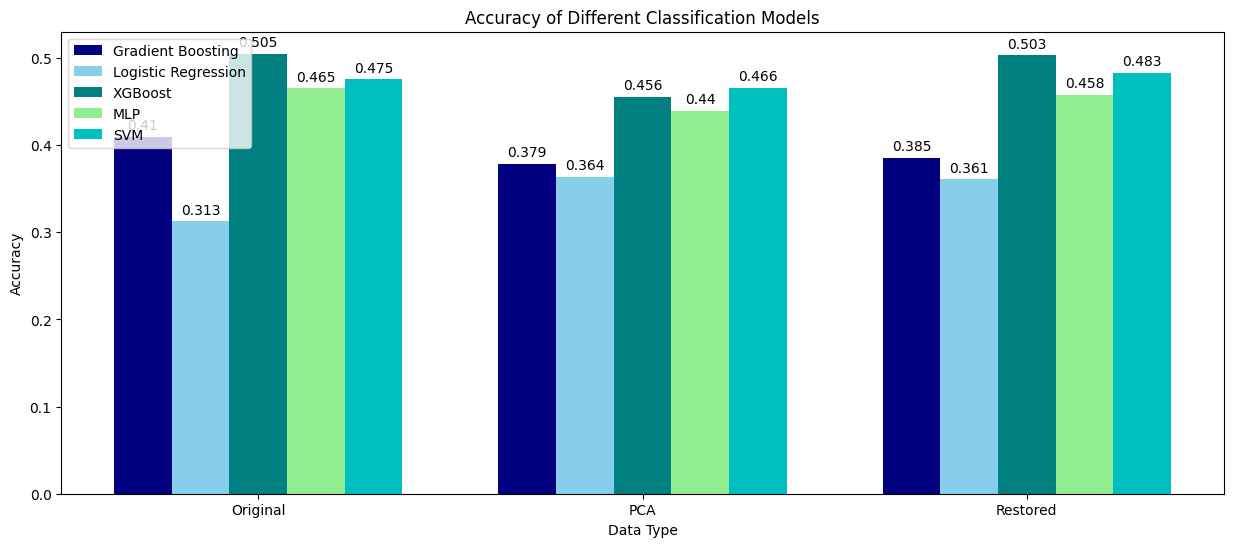

In [ ]:
# Vẽ biểu đồ
x = np.arange(len(df['Data Type']))  # Vị trí trên trục x cho các nhóm
width = 0.15  # Độ rộng của các cột

fig, ax = plt.subplots(figsize=(15, 6))

# Tạo các cột với các màu sắc được chỉ định
colors = ['navy', 'skyblue', 'teal', 'lightgreen', 'c']
bars = []

for i, (model, color) in enumerate(zip(df.columns[1:], colors)):
    bars.append(ax.bar(x + i * width, df[model], width, label=model, color=color))

# Thêm nhãn cho trục và tiêu đề
ax.set_xlabel('Data Type')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Different Classification Models')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(df['Data Type'])
ax.legend()

# Ghi chú giá trị độ chính xác trên các cột
for bar in bars:
    for rect in bar:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


Độ chính xác trung bình: Nhìn chung, độ chính xác của các mô hình không quá cao, hầu hết dao động trong khoảng từ 40% đến 50%. Điều này có thể chỉ ra rằng bài toán phân loại biểu cảm khuôn mặt này khá phức tạp và dữ liệu có thể chứa nhiều nhiễu hoặc các đặc trưng không rõ ràng giữa các lớp biểu cảm.

Trong đó XGBoost là mô hình có hiệu quả cao nhất với độ chính xác (accuracy) cao nhất trên dữ liệu gốc (0.505015) và dữ liệu đã phục hồi (0.503204). Tiếp đó chênh lệch không quá lớn là model SVM với dữ liệu phục hồi từ PCA có accuracy là gần 0.49.

&#8658; Xem xét các metrics khác để đánh giá và lựa chọn model ổn định và phù hợp.

**So sánh hiệu 2 mô hình XGBoost và SVM với  metrics khác**

Thống kê hệ số đánh giá mô hình XGBoost

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred = best_xgb_original.predict(X_test_Original)

accuracy_sklearn = accuracy_score(y_test, y_pred)
# Precision, Recall, F1-score (macro)
precision_sklearn = precision_score(y_test, y_pred, average='macro')
recall_sklearn = recall_score(y_test, y_pred, average='macro')
f1_sklearn = f1_score(y_test, y_pred, average='macro')

cm_X = confusion_matrix(y_test, y_pred)
print(cm_X)
# In kết quả của sklearn
print(f"Accuracy: {accuracy_sklearn:.4f}")
print(f"Precision: {precision_sklearn:.4f}")
print(f"Recall: {recall_sklearn:.4f}")
print(f"F1-score: {f1_sklearn:.4f}")
print(classification_report(y_test, y_pred))

[[ 331    0   65  207  172   36  174]
 [  16   31   14   13   12    3   13]
 [  82    0  348  210  213   67  123]
 [  58    0   56 1332  154   30  135]
 [  88    0   90  283  504   18  227]
 [  31    2   66  114   48  467   67]
 [  67    0   57  298  226   18  612]]
Accuracy: 0.5050
Precision: 0.5766
Recall: 0.4587
F1-score: 0.4862
              precision    recall  f1-score   support

           0       0.49      0.34      0.40       985
           1       0.94      0.30      0.46       102
           2       0.50      0.33      0.40      1043
           3       0.54      0.75      0.63      1765
           4       0.38      0.42      0.40      1210
           5       0.73      0.59      0.65       795
           6       0.45      0.48      0.47      1278

    accuracy                           0.51      7178
   macro avg       0.58      0.46      0.49      7178
weighted avg       0.51      0.51      0.50      7178




Thống kê hệ số đánh giá mô hình SVM

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred = model_svm_restored.predict(X_test_restored)

accuracy_sklearn = accuracy_score(y_test, y_pred)
# Precision, Recall, F1-score (macro)
precision_sklearn = precision_score(y_test, y_pred, average='macro')
recall_sklearn = recall_score(y_test, y_pred, average='macro')
f1_sklearn = f1_score(y_test, y_pred, average='macro')

cm_X = confusion_matrix(y_test, y_pred)
print(cm_X)
# In kết quả của sklearn
print(f"Accuracy: {accuracy_sklearn:.4f}")
print(f"Precision: {precision_sklearn:.4f}")
print(f"Recall: {recall_sklearn:.4f}")
print(f"F1-score: {f1_sklearn:.4f}")
print(classification_report(y_test, y_pred))

[[ 405    2   99  133  173   32  141]
 [  12   51   12    4   13    4    6]
 [ 117    0  404  155  159   84  104]
 [ 156    2   98 1158  165   42  164]
 [ 200    6  137  228  413   27  199]
 [  47    0   90   67   33  501   57]
 [ 170    2  114  245  154   34  559]]
Accuracy: 0.4914
Precision: 0.5034
Recall: 0.4916
F1-score: 0.4960
              precision    recall  f1-score   support

           0       0.38      0.46      0.42       985
           1       0.59      0.52      0.55       102
           2       0.59      0.63      0.61      1785
           3       0.39      0.35      0.37      1210
           4       0.69      0.65      0.67       795
           5       0.69      0.65      0.67       795
           6       0.48      0.42      0.45      1278

    accuracy                           0.49      7178
   macro avg       0.50      0.49      0.50      7178
weighted avg       0.49      0.49      0.49      7178



**Nhận xét**:
- **Accuracy**
  * Mô hình SVM: 0.4914
  * Mô hình XGBoost: 0.5050

&#8594; Mô hình XGBoost có độ chính xác cao hơn mô hình SVM, nghĩa là tỷ lệ dự đoán đúng của mô hình XGBoost trên tổng số các dự đoán cao hơn.
- **Precision**
  * Mô hình SVM: 0.5034
  * Mô hình XGBoost: 0.5766

&#8594; Mô hình XGBoost có độ chính xác tiên đoán cao hơn mô hình SVM. Điều này có nghĩa là trong số các trường hợp mà mô hình XGBoost dự đoán là biểu cảm cụ thể nào đó, tỷ lệ các dự đoán đúng cao hơn so với mô hình SVM. Mô hình XGBoost có ít dự đoán sai biểu cảm (False Positives) hơn.
- **Recall**
  * Mô hình SVM: 0.4916
  * Mô hình XGBoost: 0.4587

&#8594; Mô hình SVM có độ nhạy cao hơn mô hình XGBoost. Điều này có nghĩa là mô hình SVM có khả năng phát hiện các biểu cảm thực sự cao hơn. Mô hình SVM bỏ sót ít biểu cảm thực sự hơn (False Negatives).
- **F1-score**
  * Mô hình SVM: 0.4960
  * Mô hình XGBoost: 0.4862

&#8594; Mô hình SVM có F1-score cao hơn mô hình XGBoost. Điều này cho thấy mô hình SVM có sự cân bằng tốt hơn giữa độ chính xác tiên đoán (Precision) và độ nhạy (Recall). Mô hình XGBoost tuy có Precision cao nhưng bị đánh đổi bởi Recall thấp, dẫn đến F1-score thấp hơn.



**Kết luận**
- Mô hình XGBoost có Accuracy và Precision cao hơn: Điều này thể hiện rằng mô hình XGBoost có khả năng đưa ra nhiều dự đoán đúng hơn và ít dự đoán sai biểu cảm hơn. Tuy nhiên, do độ nhạy thấp hơn, mô hình XGBoost có thể bỏ sót nhiều biểu cảm thực sự hơn.
- Mô hình SVM có Recall và F1-score cao hơn: Điều này cho thấy mô hình SVM có khả năng phát hiện nhiều biểu cảm thực sự hơn và có sự cân bằng tốt hơn giữa Precision và Recall.

&#8658; Tùy thuộc vào yêu cầu cụ thể của bài toán phân loại biểu cảm khuôn mặt, bạn có thể chọn mô hình phù hợp:
- Mô hình XGBoost: Sử dụng khi mục tiêu chính là giảm thiểu số lượng dự đoán sai biểu cảm và tăng số lượng dự đoán đúng tổng thể, mặc dù có thể bỏ sót một số biểu cảm thực sự.
- Mô hình SVM: Sử dụng khi mục tiêu chính là phát hiện nhiều biểu cảm thực sự nhất có thể và duy trì sự cân bằng tốt giữa Precision và Recall.

**Về mặt tổng thể:**

Nhận thấy, mô hình huấn luyện có độ chính xác cao nhất chỉ khoảng 50%, kết quả này cho thấy các mô hình phân loại biểu cảm khuôn mặt này chưa đạt hiệu suất mong đợi. Một độ chính xác khoảng 50% gần như tương đương với việc đoán ngẫu nhiên trong một số trường hợp.

Nhưng khi đánh giá sâu hơn vào mô hình, ta thầy khi mô hình dự đoán là lable 1(Disgust) thì sẽ có 94% là dự đoán đúng. Ngược lại khi mô hình dự đoán lable 4(sad) thì chỉ có 38% là đúng. &#8658; Điều này cho thấy, mô hình có hoạt động hiệu quả không đồng đều ở các biểu cảm trong bộ dữ liệu.